The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


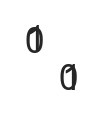

In [117]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.nn_train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

In [3]:
mpl.rcParams['figure.dpi'] = 250

In [3]:
#Reload results
encoding_weight_results = pkl_load('../output/bootstrapping/encoding_weighting.pkl')
features_results = pkl_load('../output/bootstrapping/features_results.pkl')
trainset_models_results = pkl_load('../output/bootstrapping/trainset_models.pkl')

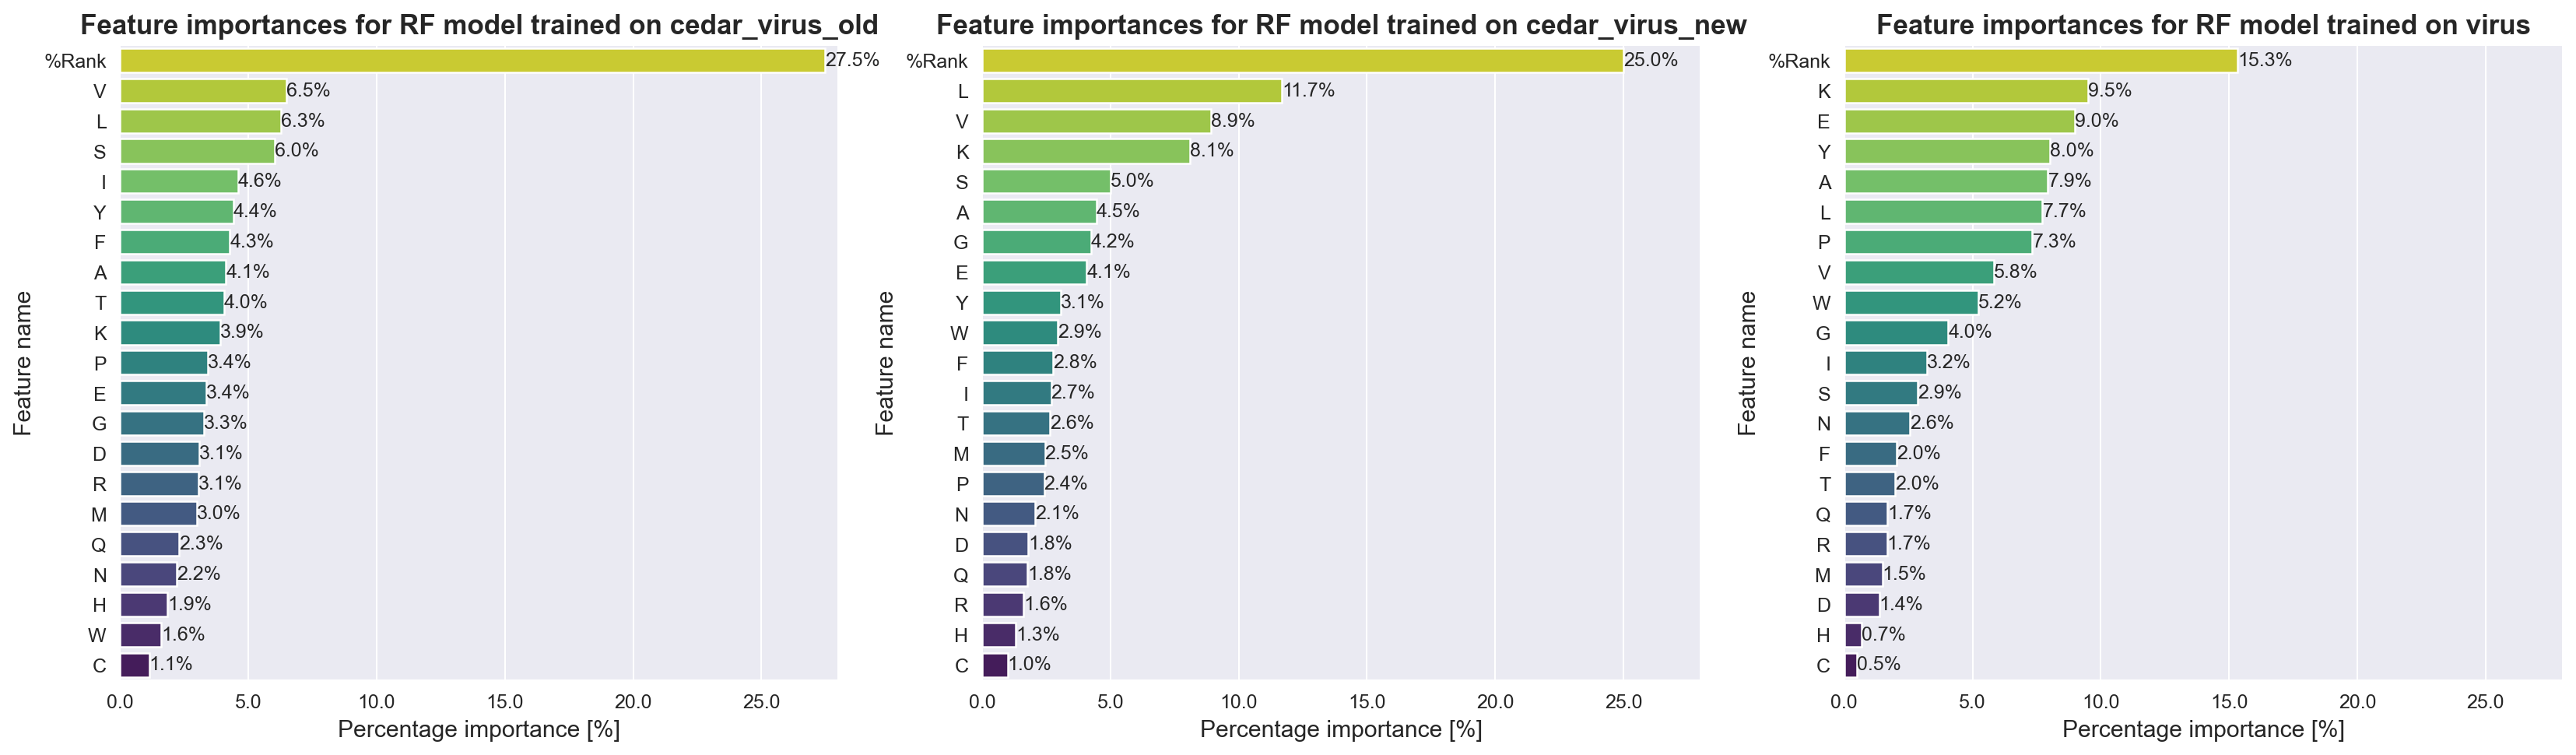

In [166]:
# VIRUS FEATURE IMPORTANCE CHECK FOR TRYPTOPHAN (W)
from src.data_processing import AA_KEYS
f, a = plt.subplots(1,3, figsize=(22.5, 6), sharex=True)
tmp = trainset_models_results['True']['RF']
i=0
plt.xlim([0,.28])
for k in tmp.keys():
    if 'vir' in k:
        
        model = tmp[k]['model']
        plot_feature_importance(get_nested_feature_importance(model), names = AA_KEYS+['%Rank'], 
                                title = f'Feature importances for RF model trained on {k}', ax = a[i], label_number=True)
        i+=1

(<Figure size 1260x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'FI for RF model trained on only CEDAR'}, xlabel='Percentage importance [%]', ylabel='Feature name'>)

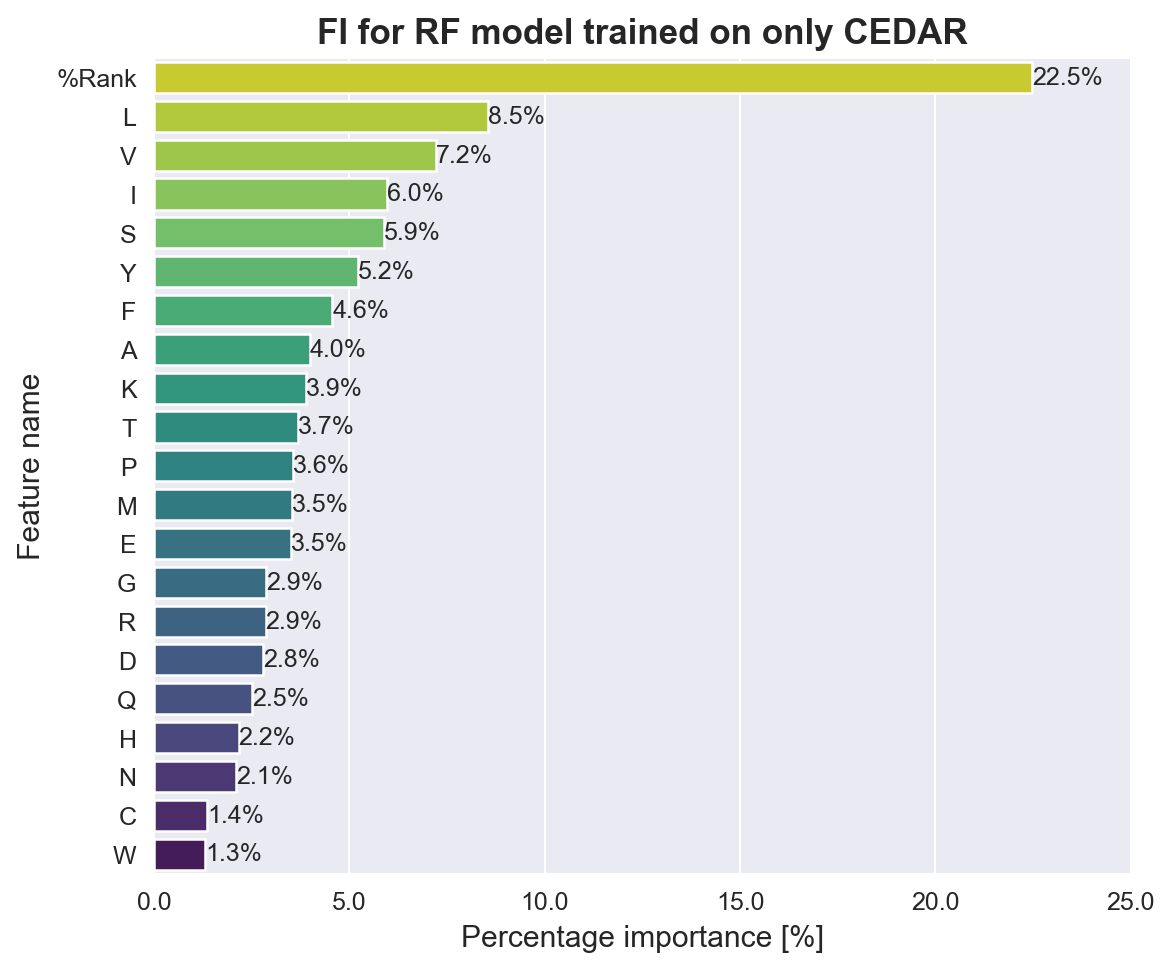

In [168]:
plot_feature_importance(get_nested_feature_importance(trainset_models_results['True']['RF']['cedar']['model']), 
                        names = AA_KEYS + ['%Rank'], title = f'FI for RF model trained on only CEDAR', label_number = True)

# init

## reloading datasets

In [4]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## reloading nnalign etc scores

In [5]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [6]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

### Merging w/ baseline scores

In [7]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [8]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

### quick roc check

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

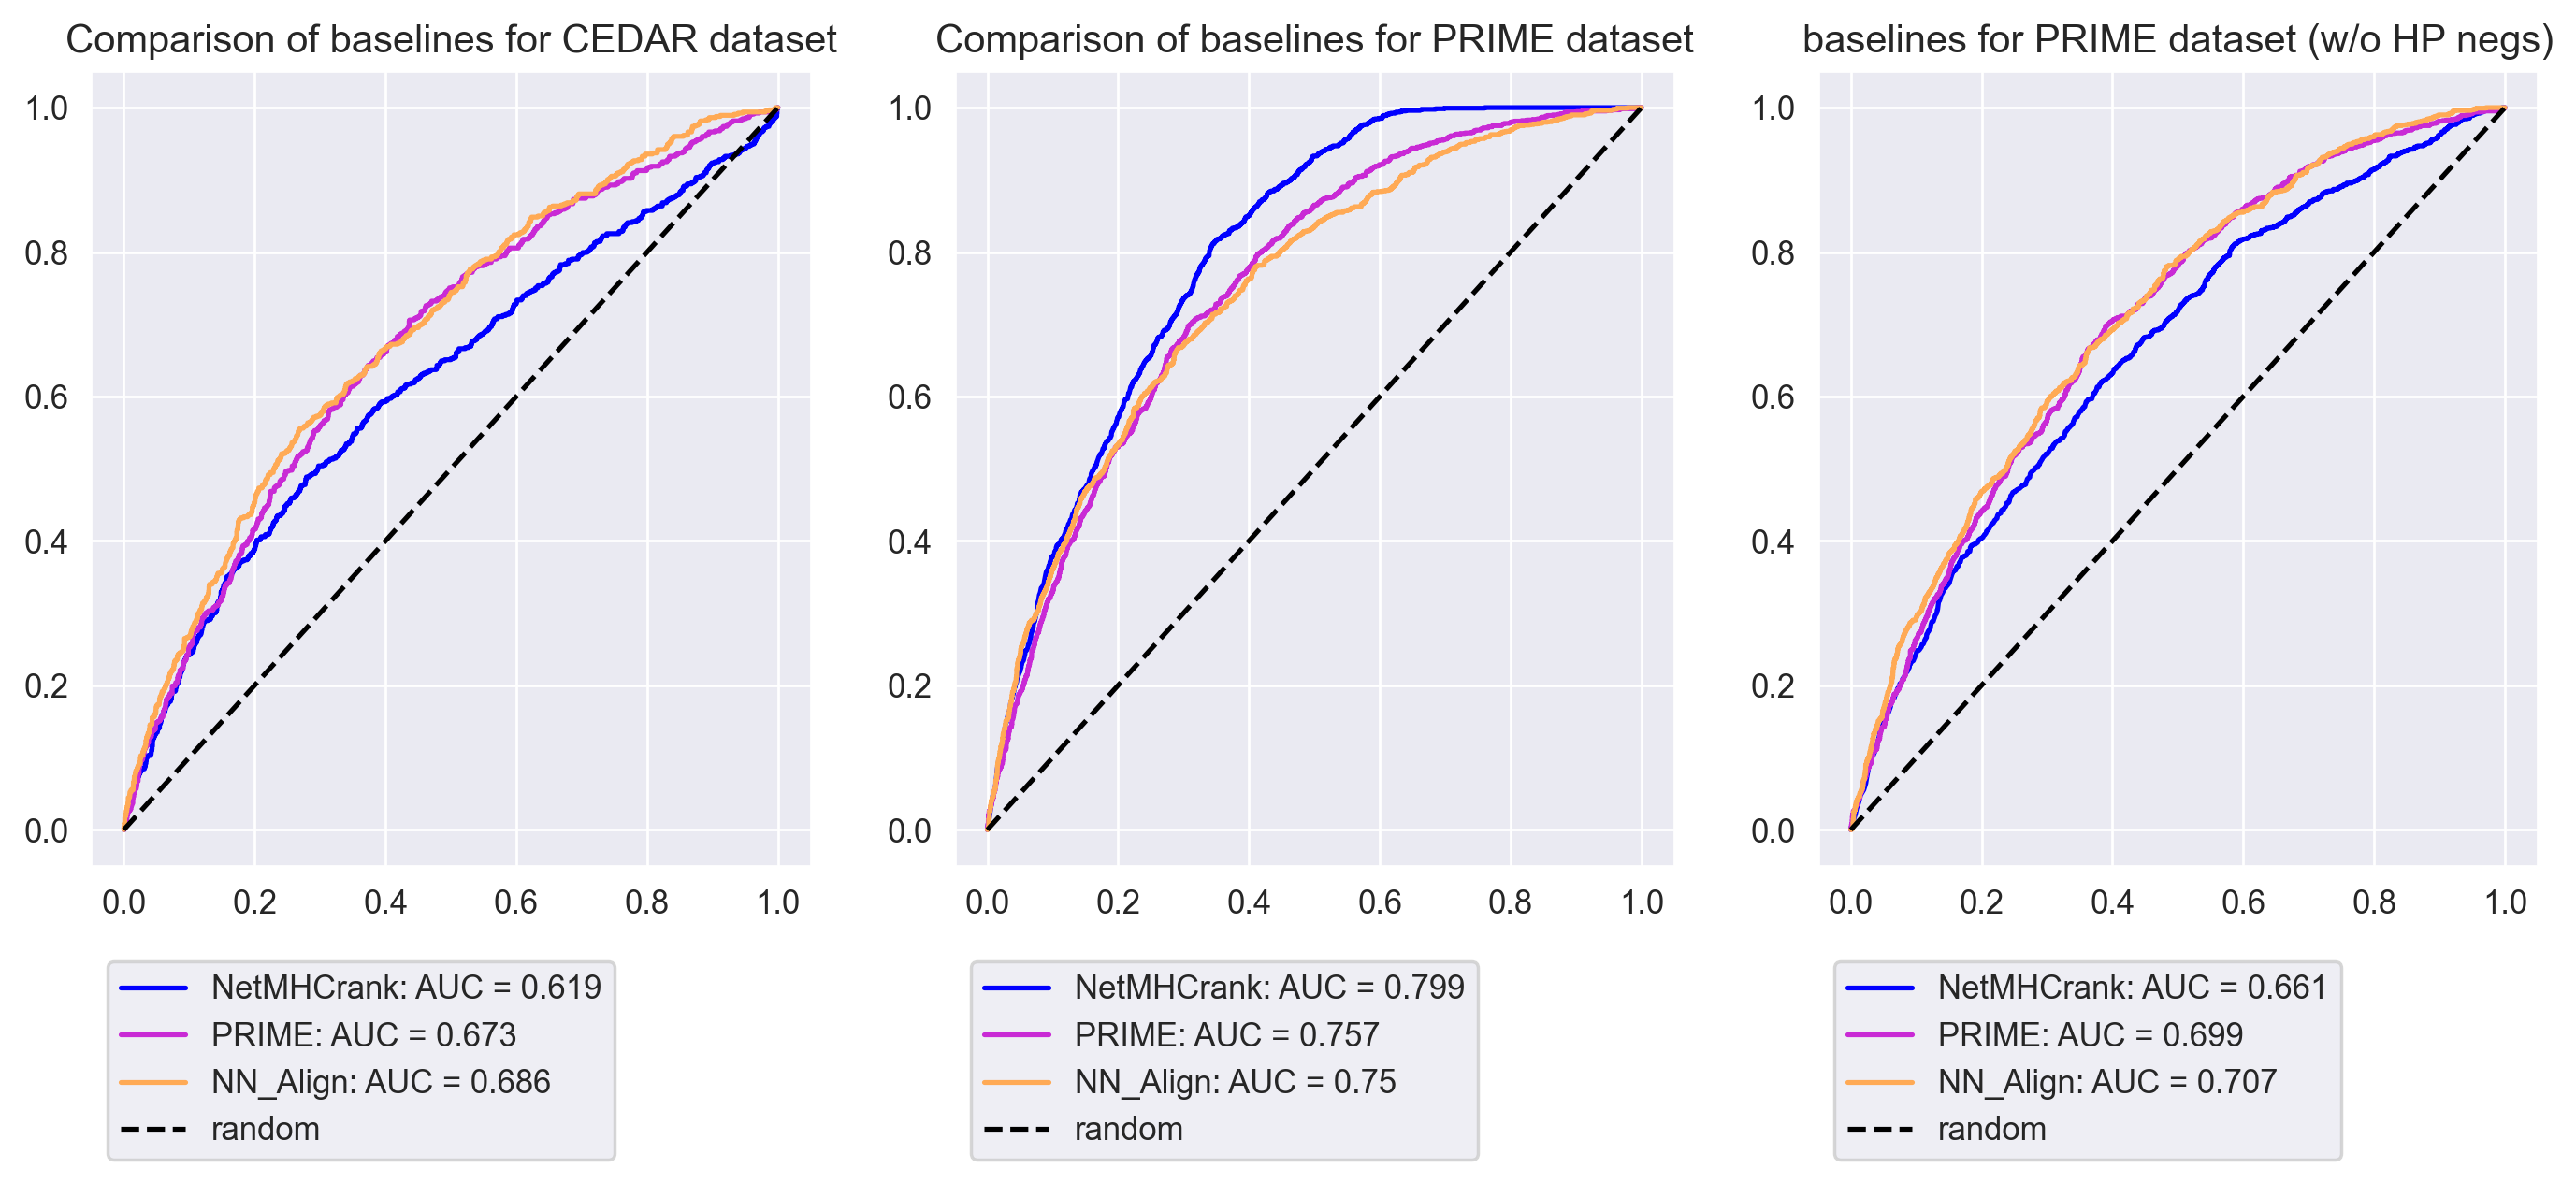

In [9]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)

a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

In [10]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
# PLOT BASELINE FUNCTIONS
def plot_baseline_roc(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        
        tmp = prime.query('StudyOrigin != "Random"') if remove_hp else prime
        
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(prime['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='--', lw=0.75, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='--', lw=0.75, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='--', lw=0.75, color='c')

    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')



# Pos-Neg distance thing (SimilariTCR)

In [109]:
# Saving pep files
s = 0
for fold in range(10):
    train_pos = cedar.query('fold != @fold and agg_label==1')
    test = cedar.query('fold == @fold')
    print(len(train_pos), len(test))
    s+=len(train_pos)
    common = [x for x in train_pos.Peptide.values if x in test.Peptide.values]
    if len(common)>1:
        print(fold, common)
    train_pos['Peptide'].to_csv(f'../../../kern_dist/data_testvspos/cedar_pos_{fold}.pep', index=False, header=False)
    test['Peptide'].to_csv(f'../../../kern_dist/data_testvspos/cedar_test_{fold}.pep', index=False, header=False)
print(s)

591 348
584 360
585 338
588 354
580 349
594 339
588 340
587 346
588 357
592 349
5877


In [111]:
# Re-reading kernel distance results
distances = []
for fold in range(10):
    with open(f'../../../kern_dist/test_pos/kern_dist/dist_out/test_pos_{fold}.dist', 'r') as f:
        for line in f.readlines():
            if line.startswith('#'):continue
            contents = line.strip('\n').split(' ')
            try: 
                distances.append({'Peptide': contents[2],
                                  'Similarity': float(contents[3]),
                                  'Neighbour': contents[5],
                                  'Fold': fold})
            except:
                pass
df_distances = pd.DataFrame(distances)
df_distances['Identical'] = df_distances.apply(lambda x: x['Peptide'] == x['Neighbour'], axis=1)
df_distances.head()

,Peptide,Similarity,Neighbour,Fold,Identical
0,AAQARLQPV,0.776252,DMKARQKALV,0,False
1,AASRSVVM,0.779563,ALNSEALSVV,0,False
2,AATPVGSLY,0.762516,ATSPASASK,0,False
3,ALFAGSMQL,0.771051,VYALIAGATL,0,False
4,ALFTWTNLLV,0.757313,TLYSLTLLY,0,False


79


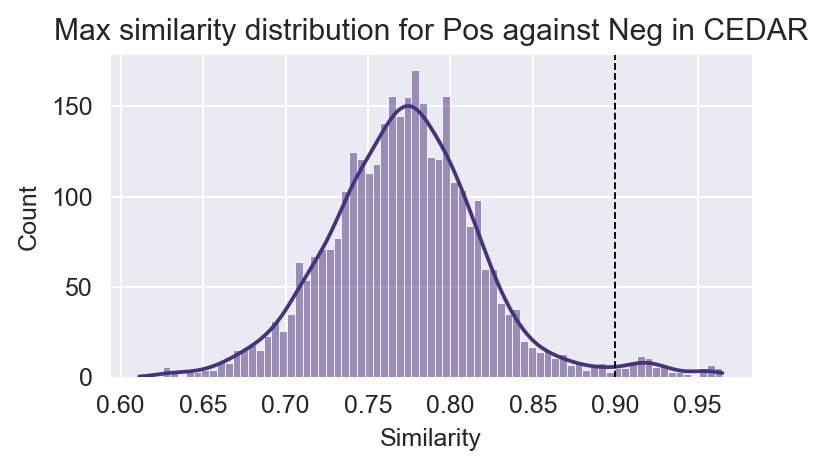

In [139]:
# Similarity distribution checks + check number of unique with Sim > 0.9
print(len(df_distances.query('Similarity>0.9').Peptide.unique()))
sns.displot(data = df_distances.drop_duplicates(), x='Similarity', kde=True, bins=75, height=2.5, aspect=1.75)
plt.title('Max similarity distribution for Pos against Neg in CEDAR')
plt.axvline(x=0.9, ls='--', lw=0.75, c='k')

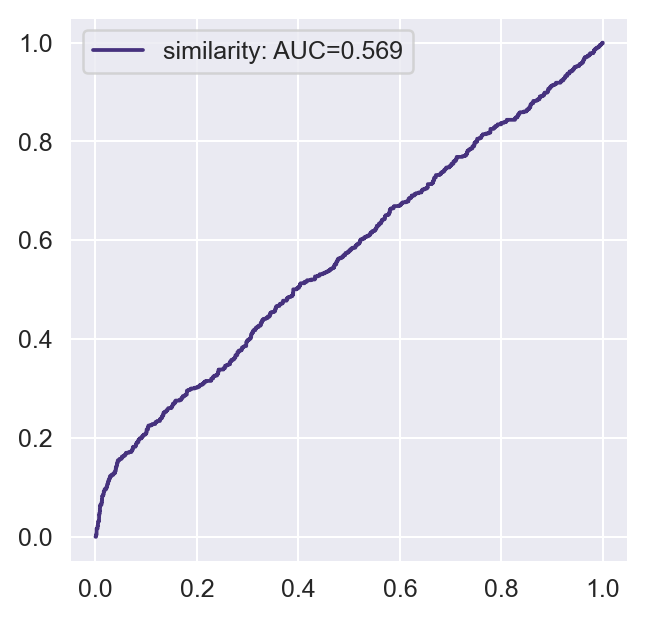

In [142]:
# AUC check using sim as score
from sklearn.metrics import roc_auc_score, roc_curve
scores = mrgd['Similarity'].values
labels = mrgd['agg_label'].values
fpr, tpr, _ = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)
f,a = plt.subplots(1,1, figsize=(4,4))
a.plot(fpr, tpr, label=f'similarity: AUC={auc.round(3)}')
a.legend()

In [143]:
print('Similarity > 90%\t', len(df_distances.query('Similarity>0.9')))
print('Identitcal: \t', len(df_distances.query('Identical == True')))
df_distances.query('Similarity>0.9').head()

Similarity > 90%	 85
Identitcal: 	 0


,Peptide,Similarity,Neighbour,Fold,Identical
19,ARLFLGLAI,0.904547,RLFLGLAIK,0,False
183,MASISSFLL,0.916829,LMASISSFL,0,False
184,MASISSFLL,0.916829,LMASISSFL,0,False
229,RLDSTLLLYHA,0.916787,RLDSTLLLY,0,False
291,TPLPGTRVRA,0.921395,STPLPGTRVR,0,False


# OVERALL BEST MODEL
Compare to baselines. --> Take the best model trained on CEDAR (+rank, None weight OneHot) --> Evaluate on PRIME
Show as "external validation" of performance  ; _maybe_ remove the peptides that are in common.

In [13]:
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.data_processing import AA_KEYS

In [ ]:
models = trainset_models_results['True']['RF']['cedar']['model']
fis = get_nested_feature_importance(models)
plot_feature_importance(fis, AA_KEYS+['%Rank'])

In [11]:
hyperparams={'bootstrap': True,
             'ccp_alpha': 4.6415888336127725e-07,
             'class_weight': None,
             'criterion': 'gini',
             'max_depth': None,
             'max_features': 'auto',
             'max_leaf_nodes': None,
             'max_samples': None,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 7,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 200,
             'oob_score': False,
             'random_state': 1,
             'verbose': 0,
             'warm_start': False}

In [12]:
# Retrain because I'm stupid and the standardize bullshit is annoying
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None
model = RandomForestClassifier()
model.set_params(**hyperparams)
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)

trained_models_hp, train_metrics_hp, _ = nested_kcv_train_sklearn(cedar_hp_uni, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [14]:
# SHANNON FEATURE IMPORTANCES

encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

model = RandomForestClassifier()
# Reload params
hyperparams = pkl_load('../output/tuning/rf_bootstrap/trainsetcedar_modelRF_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropFalse_remove_pepFalse_standardizeTrue.pkl')
hyperparams['max_depth']=None
hyperparams['n_estimators'] = int(hyperparams['n_estimators'])
model.set_params(**hyperparams)

trained_models_shannon, train_metrics_shannon, _ = nested_kcv_train_sklearn(cedar, model, ics_dict=ics_shannon,
                                                            encoding_kwargs=encoding_kwargs)
            

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

(<Figure size 1750x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature importance for Random Forest\n trained on CEDAR+HP with None weighting'}, xlabel='Percentage importance [%]', ylabel='Feature name'>)

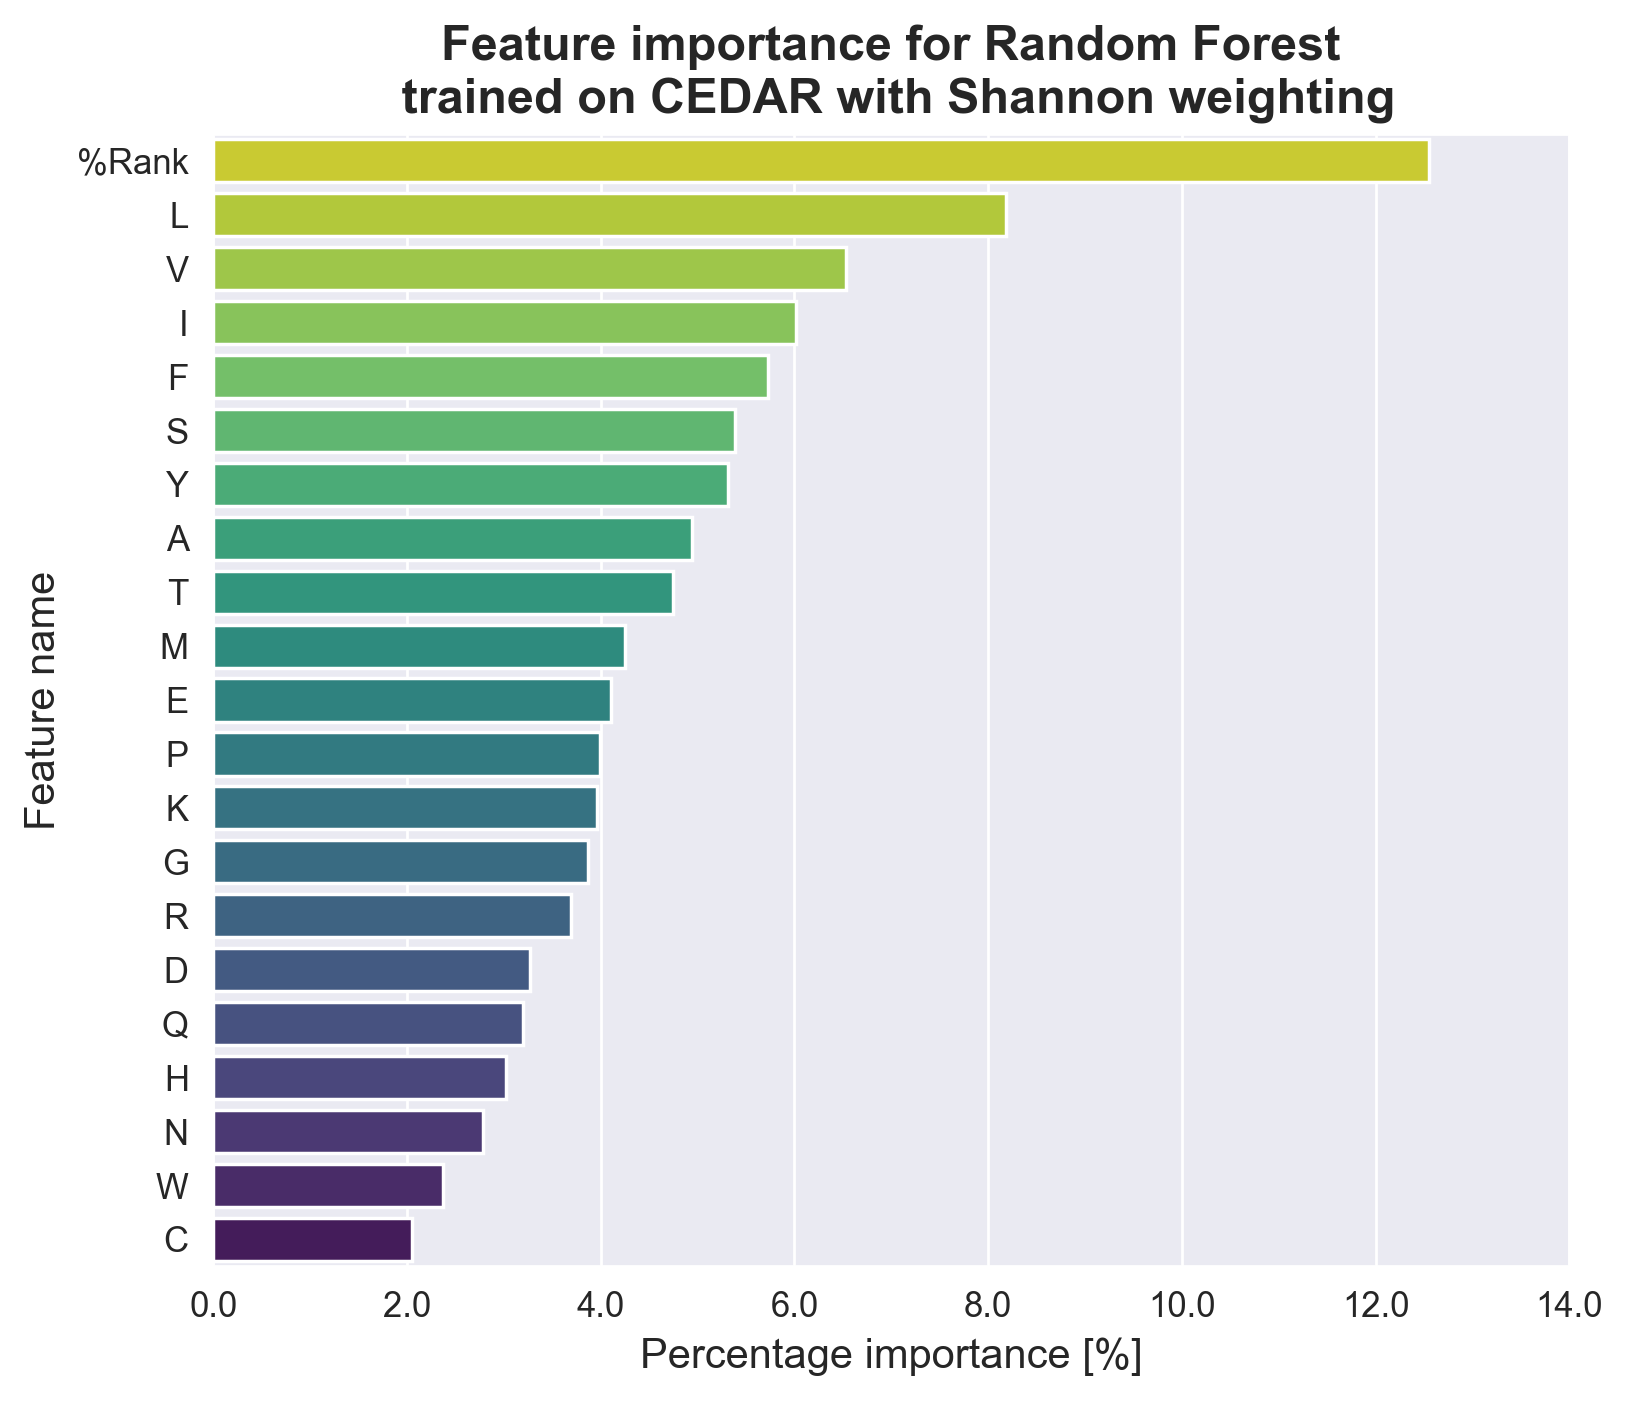

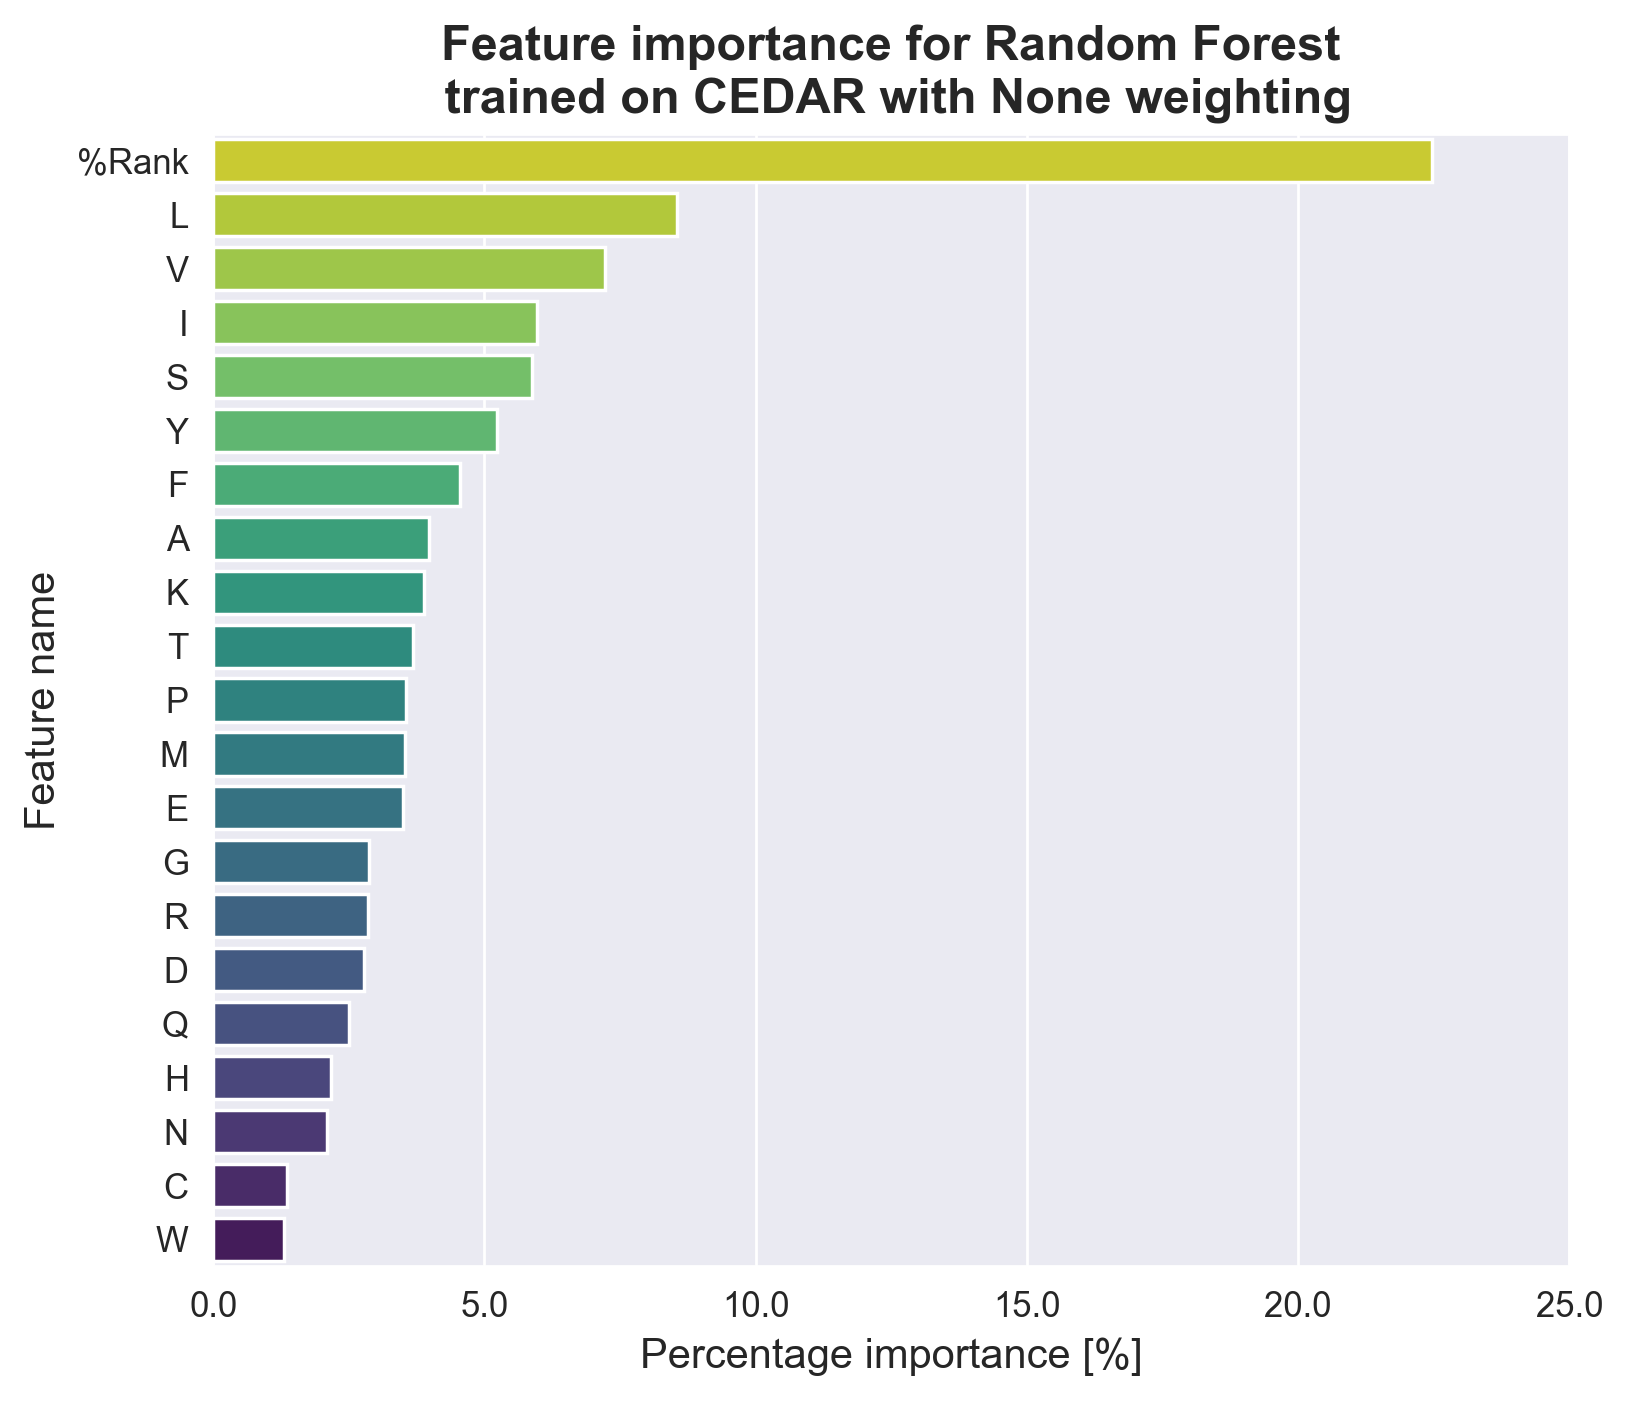

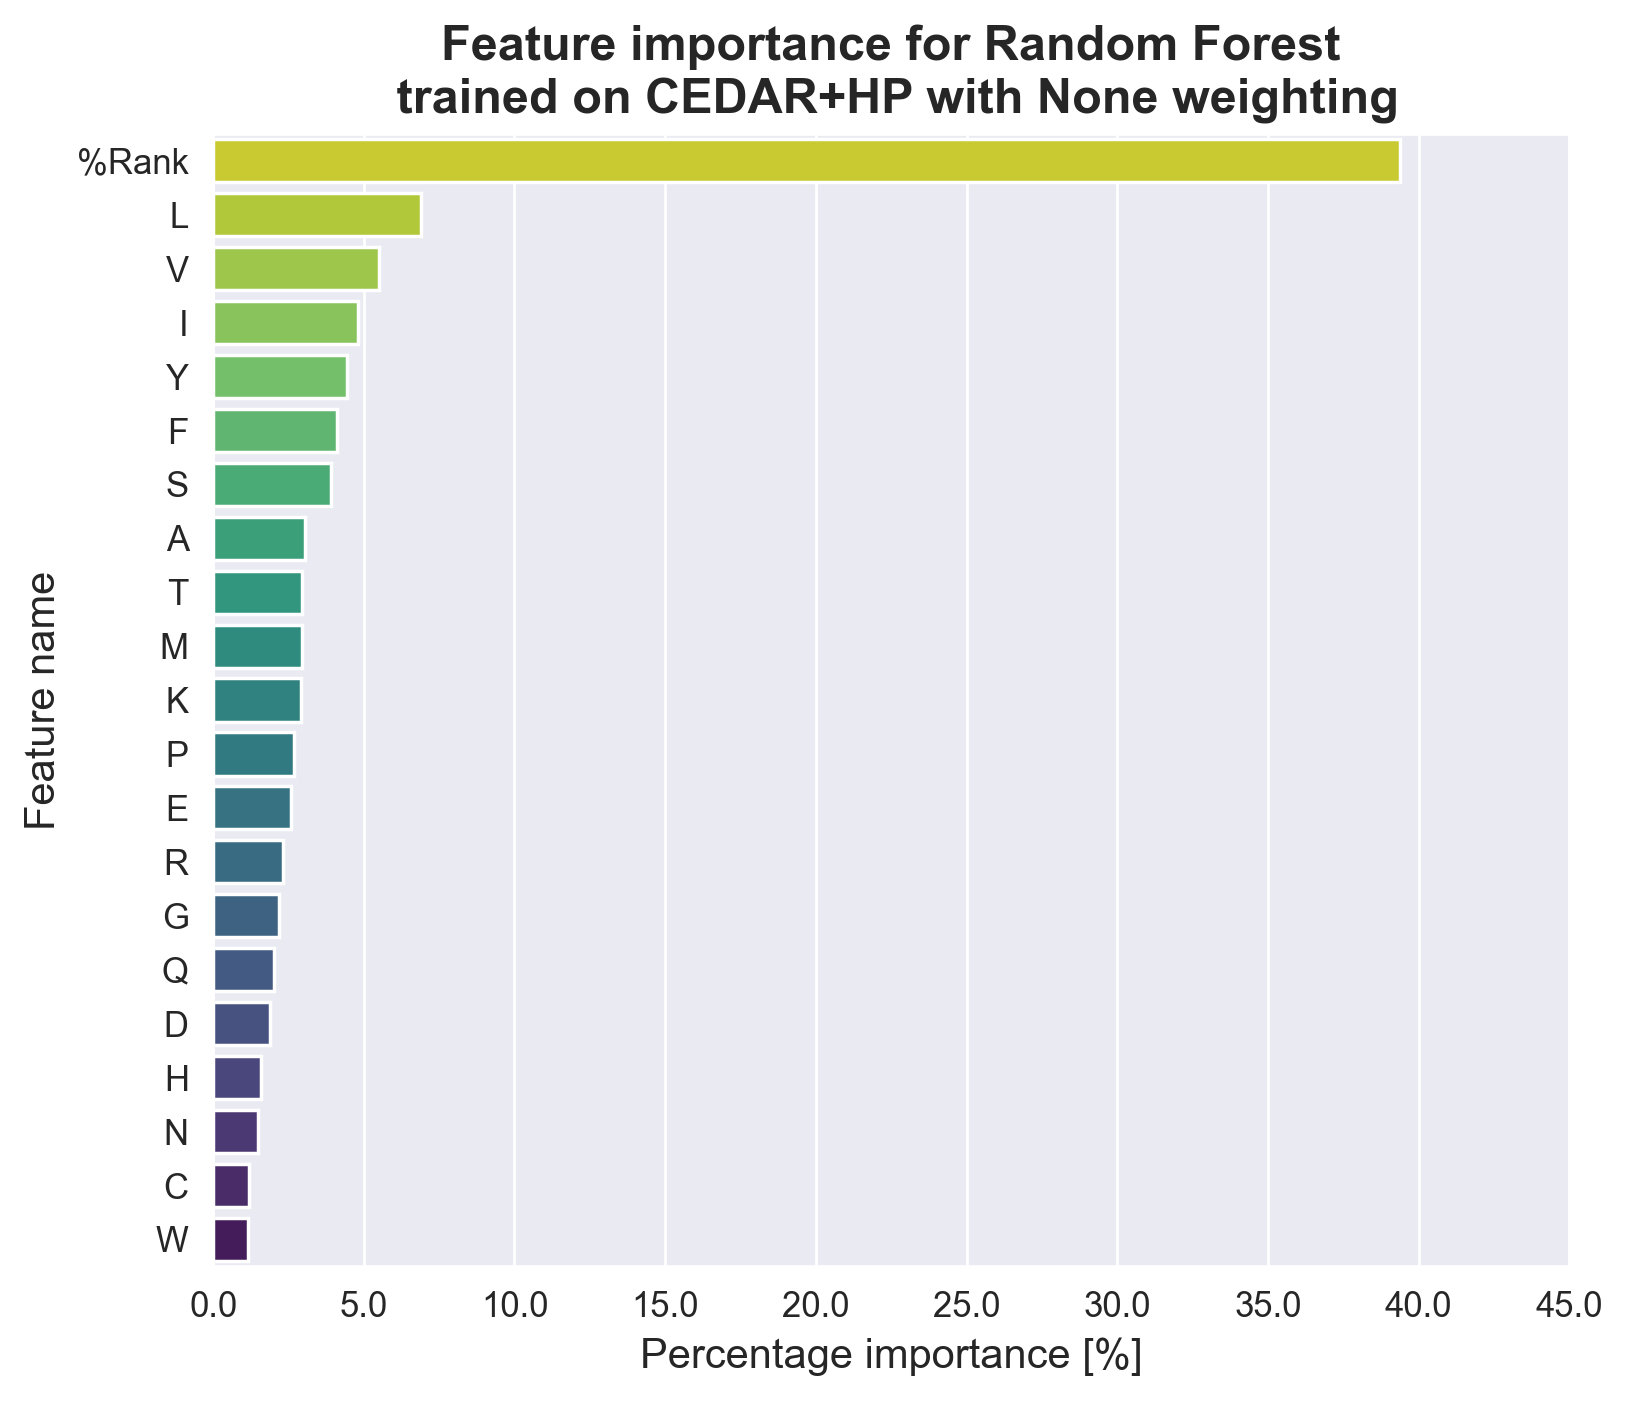

In [48]:
from src.data_processing import AA_KEYS
plot_feature_importance(get_nested_feature_importance(trained_models_shannon), AA_KEYS+['%Rank'],
                       title='Feature importance for Random Forest\n trained on CEDAR with Shannon weighting')
plot_feature_importance(get_nested_feature_importance(trained_models), AA_KEYS+['%Rank'],
                       title='Feature importance for Random Forest\n trained on CEDAR with None weighting')
plot_feature_importance(get_nested_feature_importance(trained_models_hp), AA_KEYS+['%Rank'],
                       title='Feature importance for Random Forest\n trained on CEDAR+HP with None weighting')

In [18]:
filtered_prime = prime.query('Peptide not in @cedar.Peptide.values and StudyOrigin!="Random"')
prime_benchmark, _, _ = evaluate_trained_models_sklearn(filtered_prime.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                        trained_models, None, train_dataframe=cedar,
                                                        train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                        concatenated=True, only_concat=True, keep=False, return_scores=True)

prime_benchmark_hp, _, _ = evaluate_trained_models_sklearn(filtered_prime.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                           trained_models_hp, None, train_dataframe=cedar_hp_uni,
                                                           train_metrics=train_metrics_hp, encoding_kwargs=encoding_kwargs,
                                                           concatenated=True, only_concat=True, keep=False, return_scores=True)


filtered_prime_2 = prime.query('Peptide not in @cedar.Peptide.values')
prime_benchmark_2, _, _ = evaluate_trained_models_sklearn(filtered_prime_2.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                          trained_models, None, train_dataframe=cedar,
                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                          concatenated=True, only_concat=True, keep=False, return_scores=True)

prime_benchmark_hp_2, _, _ = evaluate_trained_models_sklearn(filtered_prime_2.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                             trained_models_hp, None, train_dataframe=cedar_hp_uni,
                                                             train_metrics=train_metrics_hp, encoding_kwargs=encoding_kwargs,
                                                             concatenated=True, only_concat=True, keep=False, return_scores=True)

In [26]:
prime_benchmark_shannon, _, _ = evaluate_trained_models_sklearn(filtered_prime.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                           trained_models_shannon, ics_shannon, train_dataframe=cedar,
                                                           train_metrics=train_metrics_shannon, encoding_kwargs=encoding_kwargs,
                                                           concatenated=True, only_concat=True, keep=False, return_scores=True)

prime_benchmark_shannon_2, _, _ = evaluate_trained_models_sklearn(filtered_prime_2.rename(columns={'Immunogenicity':'agg_label',
                                                                                                           'Allele':'HLA',
                                                                                                           'NetMHCpanEL':'trueHLA_EL_rank'}), 
                                                           trained_models_shannon, ics_shannon, train_dataframe=cedar,
                                                           train_metrics=train_metrics_shannon, encoding_kwargs=encoding_kwargs,
                                                           concatenated=True, only_concat=True, keep=False, return_scores=True)

In [19]:
from src.data_processing import HLAS

In [44]:
filtered_prime_2['len'] = filtered_prime_2['Peptide'].apply(len)
filtered_prime['len'] = filtered_prime['Peptide'].apply(len)
filtered_prime_2['hla'] = filtered_prime_2['Allele'].apply(lambda x : 'HLA-'+x)
filtered_prime['hla'] = filtered_prime['Allele'].apply(lambda x : 'HLA-'+x)

Text(0.5, 1.025, 'External dataset evaluation of RandomForest models+%Rank models\nComparison of baselines and models')

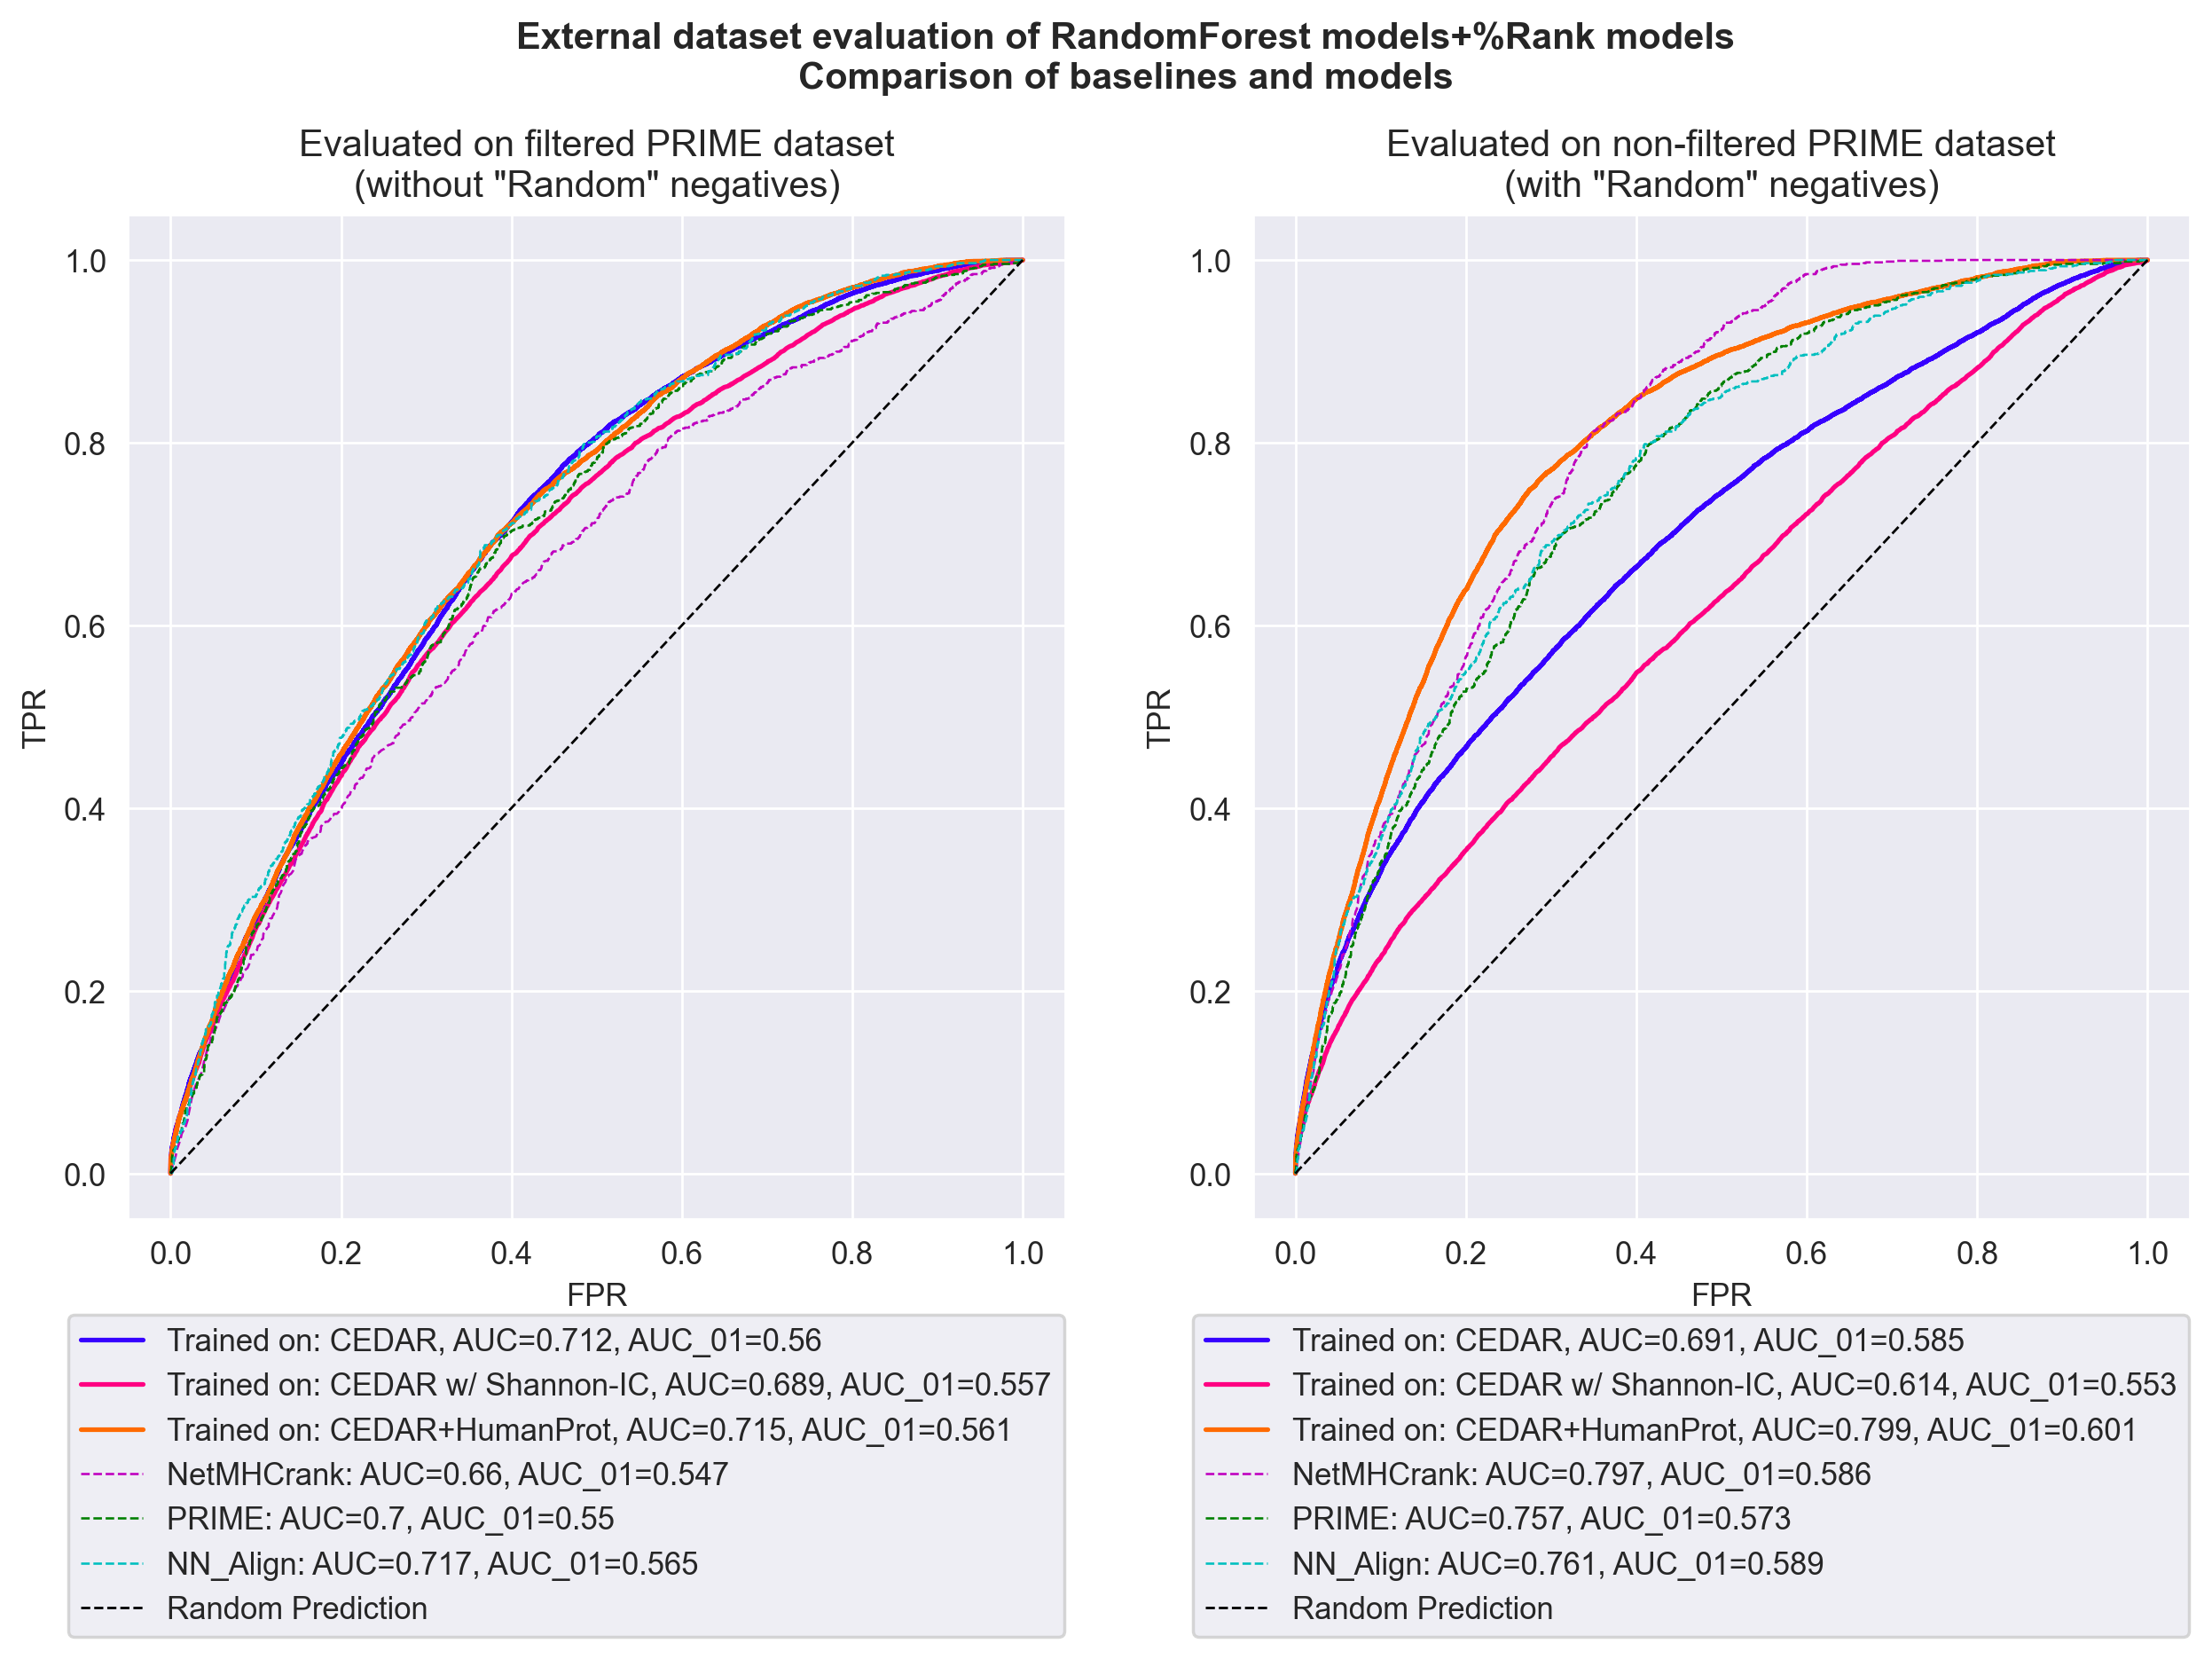

In [46]:
# External validation on PRIME
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(12,6))

for i, (tmp, tmp1, tmp2, tmp3) in enumerate(zip([filtered_prime.query('hla in @HLAS and len<=12 and len >=8'),
                                           filtered_prime_2.query('hla in @HLAS and len<=12 and len >=8')],
                                          [prime_benchmark, prime_benchmark_2],
                                          [prime_benchmark_hp, prime_benchmark_hp_2],
                                          [prime_benchmark_shannon, prime_benchmark_shannon_2])):

    if i==0:
        title = 'Evaluated on filtered PRIME dataset\n(without "Random" negatives)'
    if i==1:
        title = 'Evaluated on non-filtered PRIME dataset\n(with "Random" negatives)'
        
    model_cedar = tmp1['concatenated']
    model_cedar_hp = tmp2['concatenated']
    model_cedar_shannon = tmp3['concatenated']
    sns.lineplot(model_cedar['roc_curve'][0],
                 model_cedar['roc_curve'][1],
                 label= f"Trained on: CEDAR, AUC={round(model_cedar['auc'],3)}, AUC_01={round(model_cedar['auc_01'],3)}",
                 estimator=None, ax=a[i])

    
    sns.lineplot(model_cedar_shannon['roc_curve'][0],
                 model_cedar_shannon['roc_curve'][1],
                 label= f"Trained on: CEDAR w/ Shannon-IC, AUC={round(model_cedar_shannon['auc'],3)}, AUC_01={round(model_cedar_shannon['auc_01'],3)}",
                 estimator=None, ax=a[i])
    sns.lineplot(model_cedar_hp['roc_curve'][0],
                 model_cedar_hp['roc_curve'][1],
                 label= f"Trained on: CEDAR+HumanProt, AUC={round(model_cedar_hp['auc'],3)}, AUC_01={round(model_cedar_hp['auc_01'],3)}",
                 estimator=None, ax=a[i])
    fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
    auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
    # PRIME
    fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
    auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
    
    # nnalign
    fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    auc_netmhc_01 = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values, max_fpr=0.1)
    auc_prime_01 = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values, max_fpr=0.1)
    auc_nnalign_01 = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values, max_fpr=0.1)
    
        
    a[i].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC={round(auc_netmhc,3)}, AUC_01={round(auc_netmhc_01,3)}',
              linestyle='--', lw=0.75, color='m')
    a[i].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC={round(auc_prime,3)}, AUC_01={round(auc_prime_01,3)}',
              linestyle='--', lw=0.75, color='g')
    a[i].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC={round(auc_nnalign,3)}, AUC_01={round(auc_nnalign_01,3)}',
              linestyle='--', lw=0.75, color='c')
    a[i].set_xlabel('FPR', fontweight='normal')
    a[i].set_ylabel('TPR', fontweight='normal')
    a[i].set_title(title, fontweight='normal')
    a[i].plot([0,1], [0,1], ls='--', lw=.8, label = 'Random Prediction', c='k')
    a[i].legend(bbox_to_anchor=(1.015, -.08))
    # plot_baseline_roc(axis=a, dataset='prime', remove_hp=False)
f.suptitle('External dataset evaluation of RandomForest models+%Rank models\n'\
           'Comparison of baselines and models', fontweight='bold', fontsize=12, y=1.025) 


In [96]:
# Same validation on CEDAR
cedar_benchmark, cedar_pred = evaluate_trained_models_sklearn(cedar, 
                                                        trained_models, None, train_dataframe=cedar,
                                                        train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                        concatenated=True, only_concat=True, keep=False, return_scores=True)

# cedar_benchmark_hp, cedar_hp_pred = evaluate_trained_models_sklearn(cedar, 
#                                                            trained_models_hp, None, train_dataframe=cedar_hp_uni,
#                                                            train_metrics=train_metrics_hp, encoding_kwargs=encoding_kwargs,
#                                                            concatenated=True, only_concat=True, keep=False, return_scores=True)

cedar_benchmark_shannon, shannon_pred = evaluate_trained_models_sklearn(cedar, 
                                                           trained_models_shannon, ics_shannon, train_dataframe=cedar,
                                                           train_metrics=train_metrics_shannon, encoding_kwargs=encoding_kwargs,
                                                           concatenated=True, only_concat=True, keep=False, return_scores=True)

In [89]:
nnalign_scores = nnalign_cedar.sort_values('Peptide', ascending=False).Prediction.values 
rf_scores = cedar_pred.mean_pred.values

In [90]:
nnalign_cedar

,Core,P1,Measure,Prediction,Peptide,Gap_pos,Gap_lgt,Insert_pos,Insert_lgt,Core+gap,P1_Rel
0,KRPIPI,1,1.000,0.10276,QKRPIPIKYKAM,0,0,0,0,KRPIPI,0.25
1,WRNGST,2,0.001,0.04919,AEWRNGSTSSL,0,0,0,0,WRNGST,0.20
2,ISPGGV,1,0.001,0.06163,AISPGGVQEAL,0,0,0,0,ISPGGV,0.30
3,RWRCLV,5,0.001,0.07129,ALAQERWRCLV,0,0,0,0,RWRCLV,0.45
4,ALFTAD,0,0.001,0.08686,ALFTADSAQTK,0,0,0,0,ALFTAD,0.75
...,...,...,...,...,...,...,...,...,...,...,...
3475,WLTGFL,0,0.001,0.22029,WLTGFLLA,0,0,0,0,WLTGFL,0.80
3476,YTHNLI,1,0.001,0.15695,WYTHNLIF,0,0,0,0,YTHNLI,0.35
3477,YLIRRE,0,0.001,0.10112,YLIRREKV,0,0,0,0,YLIRRE,0.85
3478,YTHNLI,0,0.001,0.18082,YTHNLIFV,0,0,0,0,YTHNLI,0.60


Text(0.5, 1.0, 'External dataset evaluation of RandomForest models+%Rank models\nComparison of baselines and models on CEDAR test set')

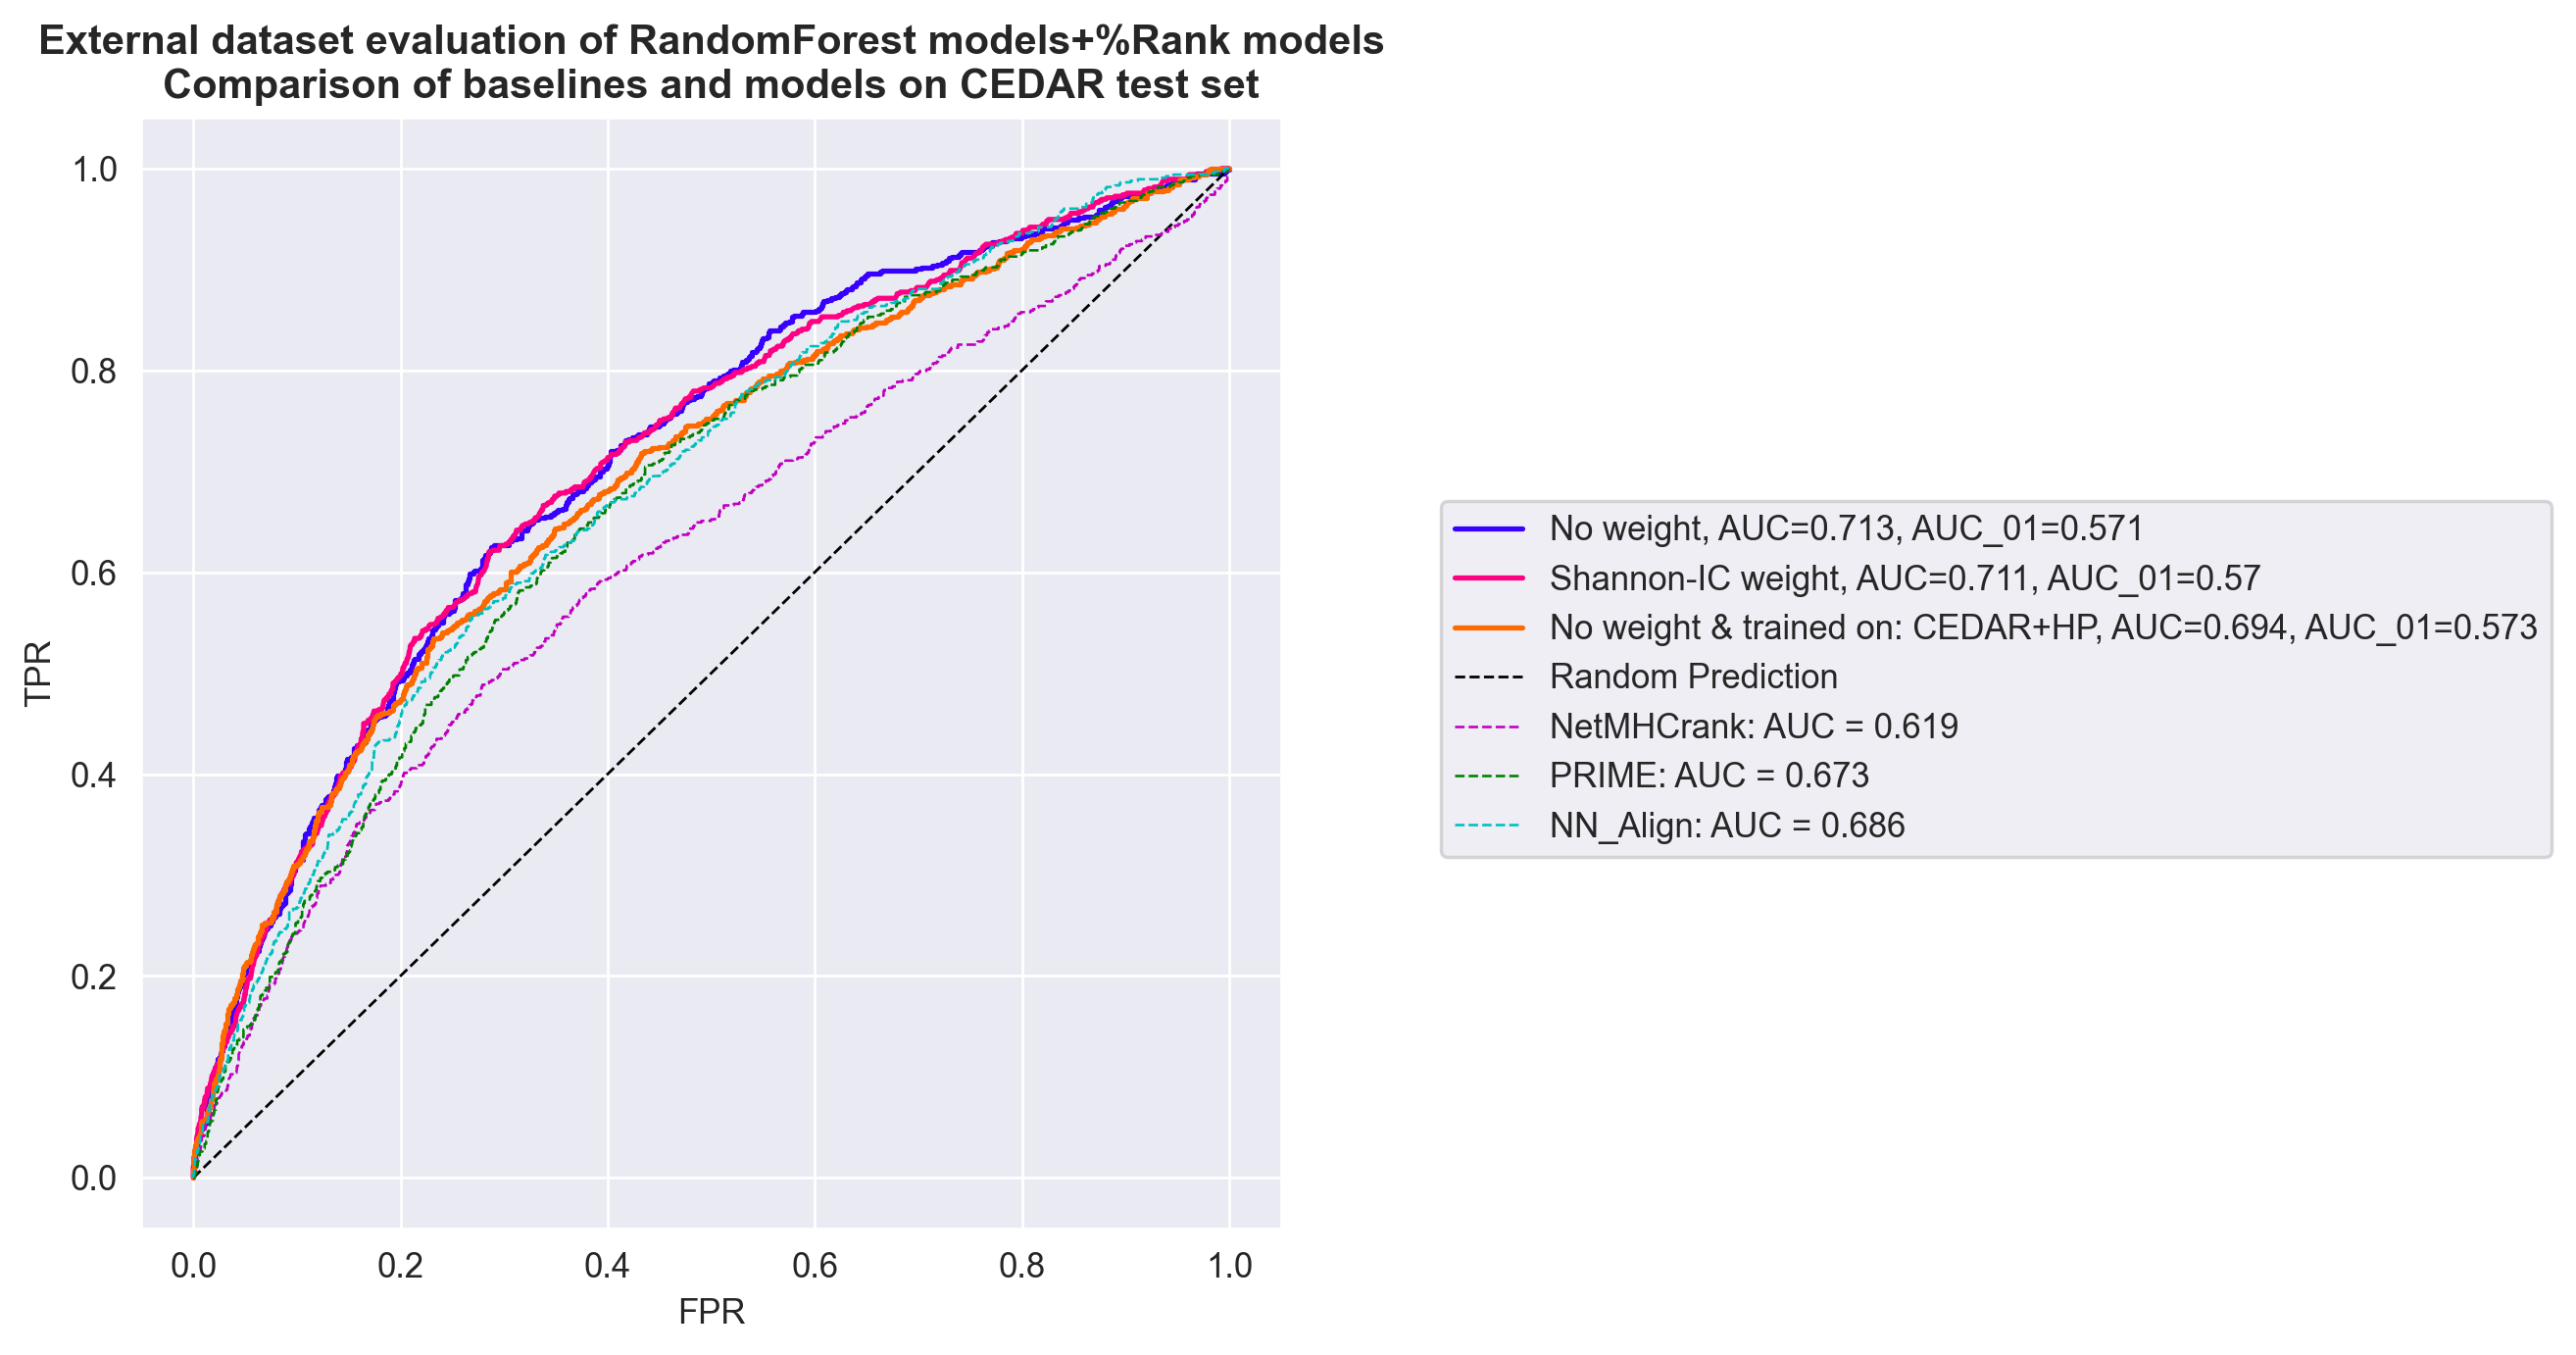

In [42]:
# External validation on PRIME
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(6,6))


model_cedar = cedar_benchmark['concatenated']
model_cedar_hp = cedar_benchmark_hp['concatenated']
model_cedar_shannon = cedar_benchmark_shannon['concatenated']
sns.lineplot(model_cedar['roc_curve'][0],
             model_cedar['roc_curve'][1],
             label= f"No weight, AUC={round(model_cedar['auc'],3)}, AUC_01={round(model_cedar['auc_01'],3)}",
             estimator=None, ax=a)



sns.lineplot(model_cedar_shannon['roc_curve'][0],
             model_cedar_shannon['roc_curve'][1],
             label= f"Shannon-IC weight, AUC={round(model_cedar_shannon['auc'],3)}, AUC_01={round(model_cedar_shannon['auc_01'],3)}",
             estimator=None, ax=a)

sns.lineplot(model_cedar_hp['roc_curve'][0],
             model_cedar_hp['roc_curve'][1],
             label= f"No weight & trained on: CEDAR+HP, AUC={round(model_cedar_hp['auc'],3)}, AUC_01={round(model_cedar_hp['auc_01'],3)}",
             estimator=None, ax=a)

a.set_xlabel('FPR', fontweight='normal')
a.set_ylabel('TPR', fontweight='normal')
# a.set_title(title, fontweight='normal')
a.plot([0,1], [0,1], ls='--', lw=.8, label = 'Random Prediction', c='k')
plot_baseline_roc(axis=a, dataset='cedar')
a.legend(bbox_to_anchor=(2.13, .67))
    # plot_baseline_roc(axis=a, dataset='prime', remove_hp=False)
a.set_title('External dataset evaluation of RandomForest models+%Rank models\n'\
           'Comparison of baselines and models on CEDAR test set', fontweight='bold', fontsize=12)#, y=1.025) 


## reget logo

In [ ]:
pep = cedar.query('HLA=="HLA-A01:01" and len==9').sample(1)
feats= get_dataset(pep, ics_dict = None,
                                   mask=True, add_rank=True)[0]
xs = {k:v for k,v in zip(AA_KEYS+['%Rank'], feats.flatten())}
pd.DataFrame(xs, index=[0])

# Dataset checks

In [ ]:
# Using the motif of length 8 instead
nnalign_cedar = pd.read_csv(f'{nndir}/../cedar.pep_22581/cedar.pep_22581.lg8.sorted.pred', sep = '\t')
y_true = nnalign_cedar['Measure'].apply(lambda x: int(x))
roc_auc_score(y_true, nnalign_cedar['Prediction'].values)

In [ ]:
raw_epitopes = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name = 'epitopes')
raw_short = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name = 'short')
raw_epitopes['len'] = raw_epitopes['Epitope_Description'].apply(len)
raw_epitopes.query('Epitope_Description not in @cedar.Peptide.values and `MHC_Allele Name`.str.contains("D")', engine='python')

In [49]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [ ]:
for x in [cedar, cedar_viral_old, cedar_viral_more, prime_fold, viral_only, cedar_hp_uni, cedar_hp_low]:
    name = x.trainset.unique()[0]
    n_tot = len(x)
    n_pos = len(x.query('agg_label==1'))
    print(f'{name}: tot={n_tot}, n_pos={round(n_pos/n_tot,3):.1%}')

In [ ]:
sns.set_palette(HSV)

In [ ]:
g = sns.displot(data=cedar_hp_uni.rename(columns={'agg_label':'Label'}), x='trueHLA_EL_rank', 
                hue='Label', kind='hist', kde=True, height=5, aspect=1.5)
plt.title('Distribution of %Rank for each class for CEDAR+HP (uniform)')
plt.xlabel('%EL Rank')


Text(0.5, 23.611111111111168, '%EL Rank')

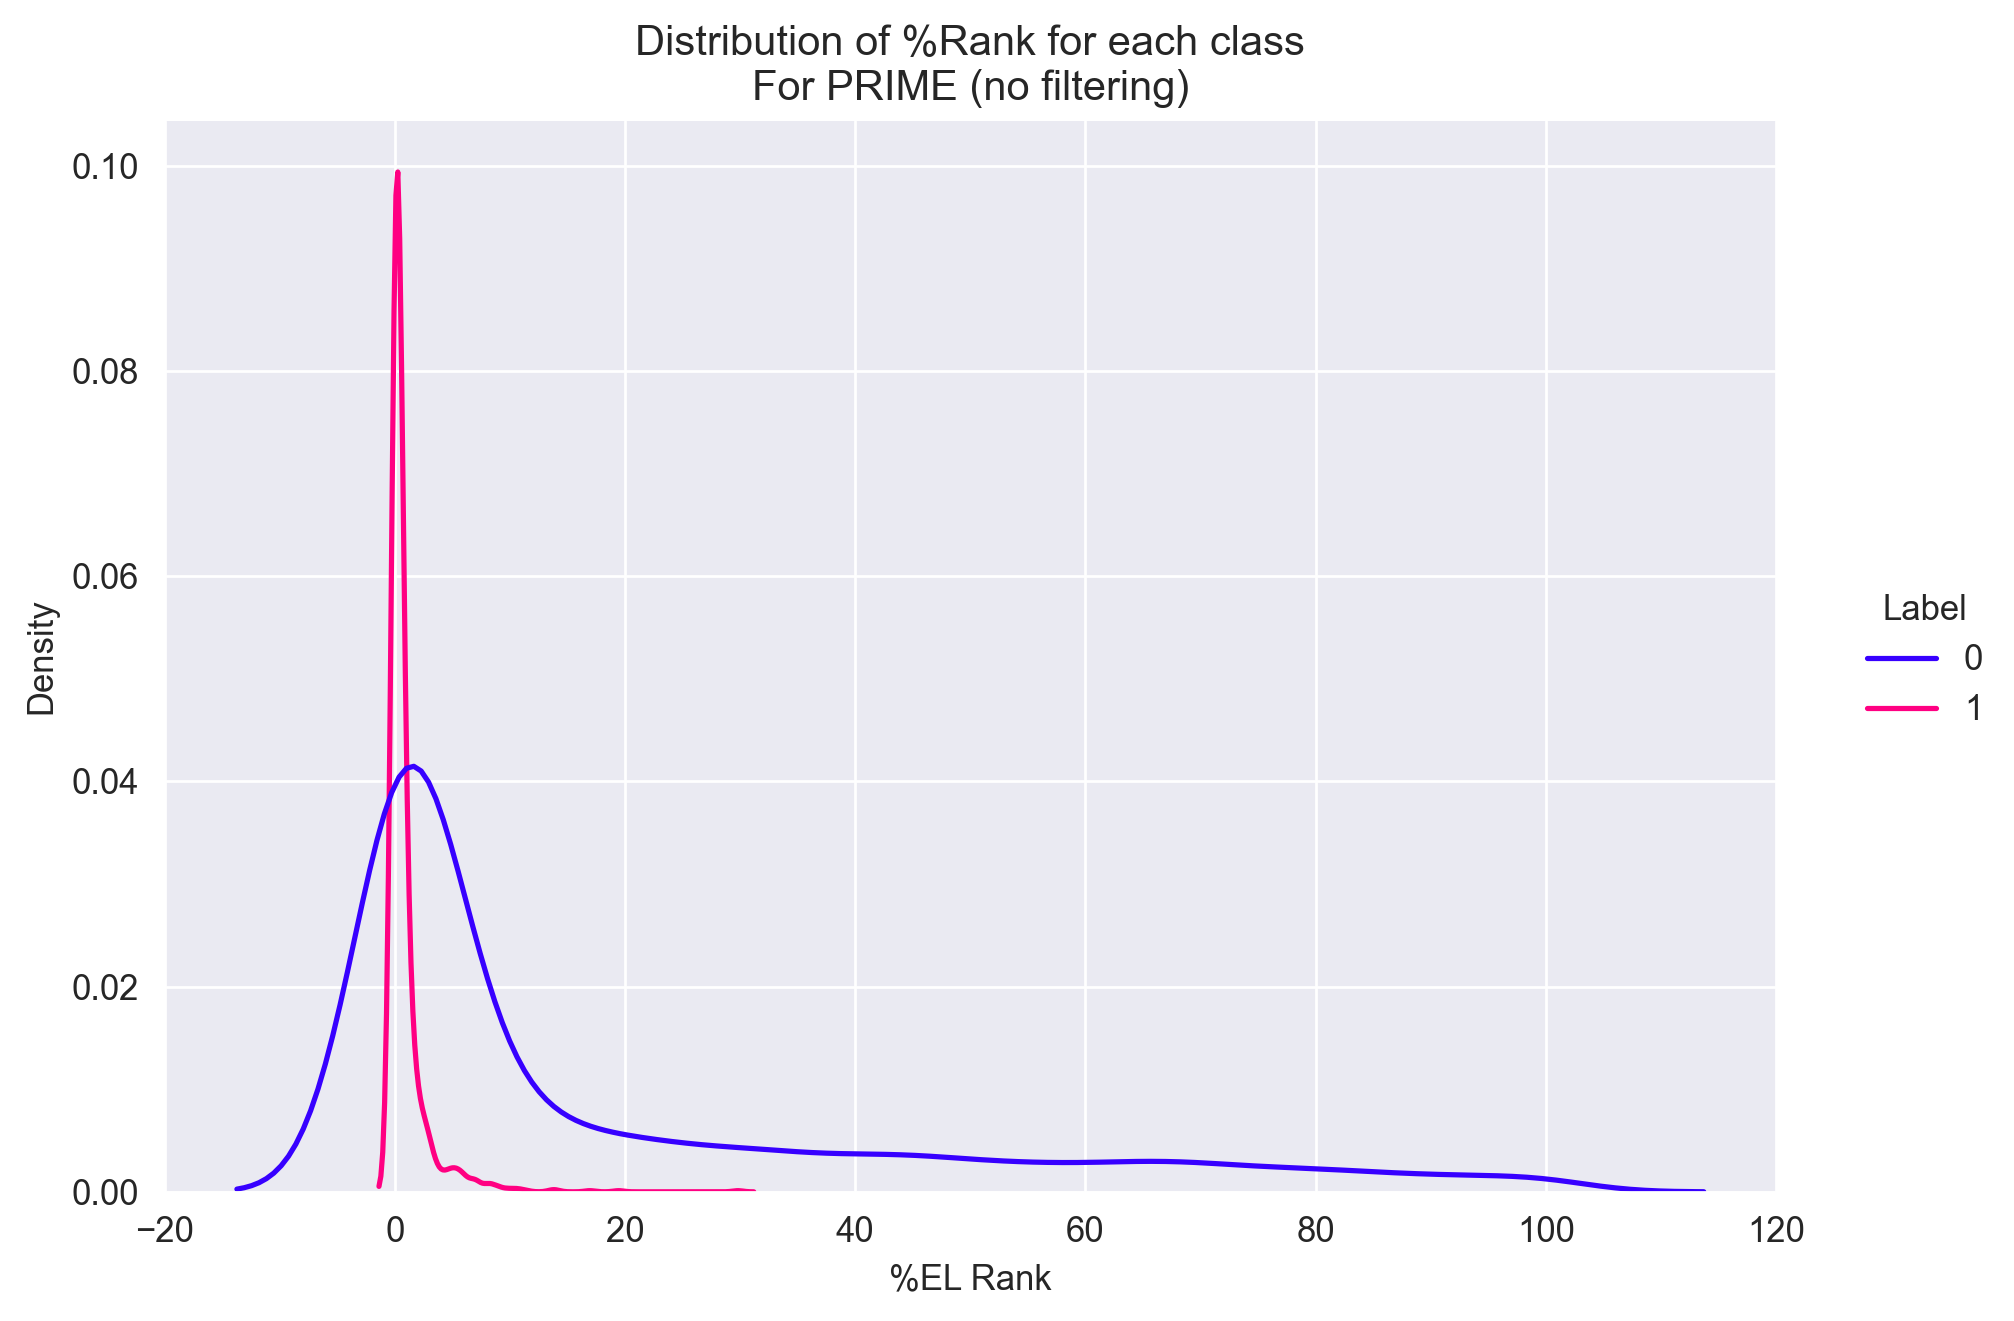

In [54]:
sns.set_palette(HSV)
g = sns.displot(data=prime.rename(columns={'Immunogenicity':'Label'}), x='NetMHCpanEL', 
                hue='Label', kind='kde', height=5, aspect=1.5)
plt.title('Distribution of %Rank for each class\nFor PRIME (no filtering)')
plt.xlabel('%EL Rank')


Text(0.5, 23.611111111111168, '%EL Rank')

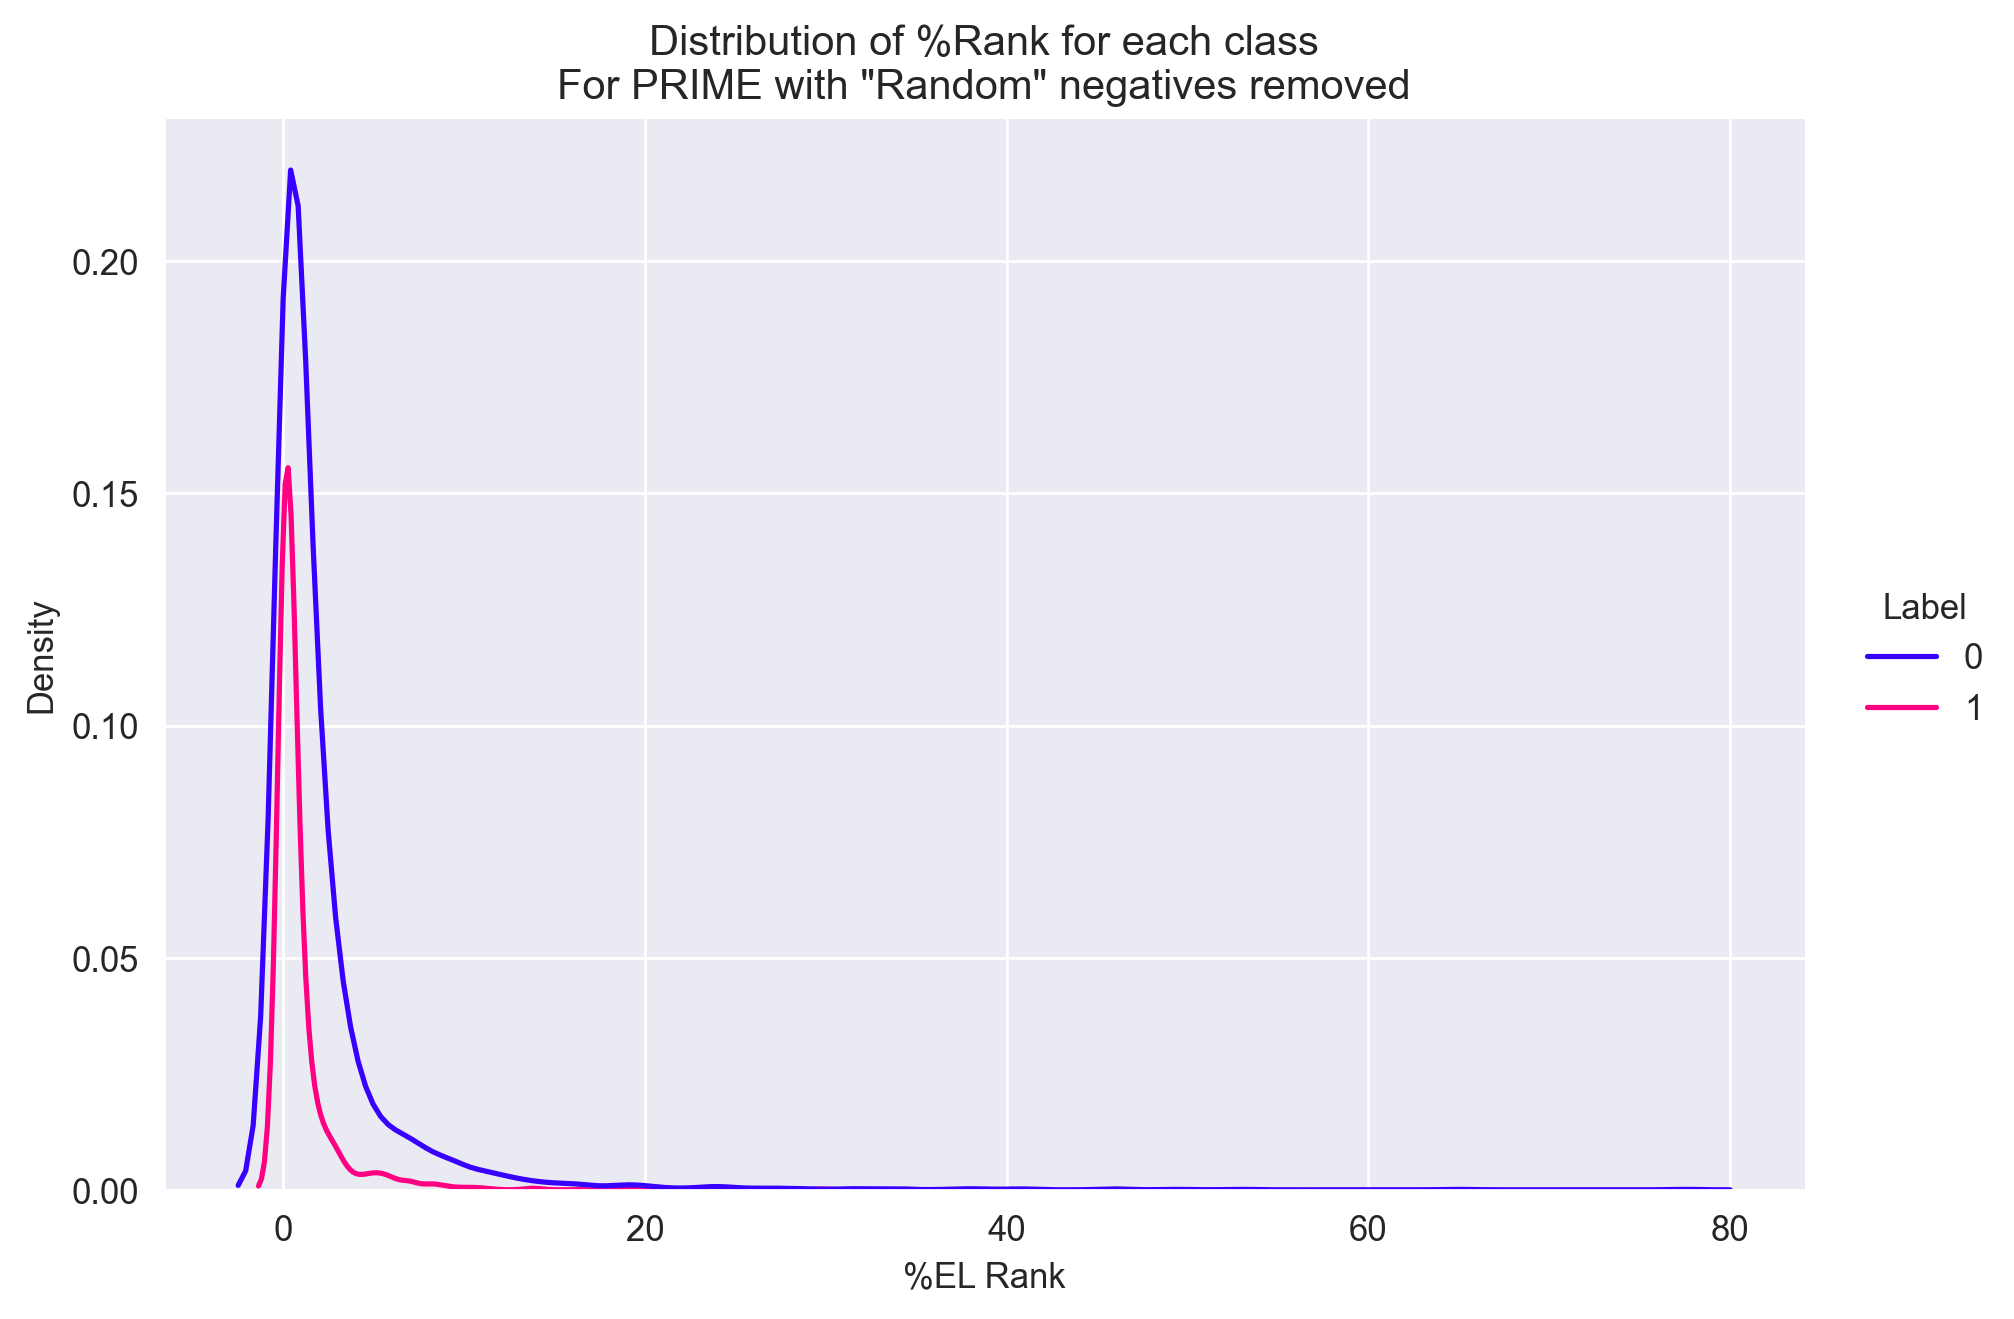

In [53]:
sns.set_palette(HSV)
g = sns.displot(data=prime.query('StudyOrigin!="Random"').rename(columns={'Immunogenicity':'Label'}), x='NetMHCpanEL', 
                hue='Label', kind='kde', height=5, aspect=1.5)
plt.title('Distribution of %Rank for each class\nFor PRIME with "Random" negatives removed')
plt.xlabel('%EL Rank')


In [ ]:
g = sns.displot(data=cedar.rename(columns={'agg_label':'Label'}), x='trueHLA_EL_rank', 
                hue='Label', kind='hist', kde=True, height=5, aspect=1.5, bins = 70)
plt.title('Distribution of %Rank for each class for CEDAR')
plt.xlabel('%EL Rank')


In [ ]:
g = sns.displot(data=cedar_hp_uni.rename(columns={'agg_label':'Label'}), x='trueHLA_EL_rank', 
                hue='Label', kind='hist', kde=True, height=5, aspect=1.5)
plt.title('Distribution of %Rank for each class for CEDAR+HP (uniform)')
plt.xlabel('%EL Rank')


## IC weight

In [ ]:
ics = [{k:round(v,3) for k,v in zip([f'Pos {i+1}' for i in range(9)], ics_shannon[9]['HLA-A0101'][0.25])},
       {k:1-round(v,3) for k,v in zip([f'Pos {i+1}' for i in range(9)], ics_shannon[9]['HLA-A0101'][0.25])}]

In [ ]:
pd.DataFrame(ics, index=['IC', 'Weight (1-IC)'])

In [ ]:
def get_ic_weights(df, ics_dict: dict, max_len=None, seq_col='Peptide', hla_col='HLA', mask=False):


# reget bootstrap plots

## box violins

In [55]:
df_rank_trainset_model_cedar = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv')

Text(0, 0.5, 'Test AUC (CEDAR)')

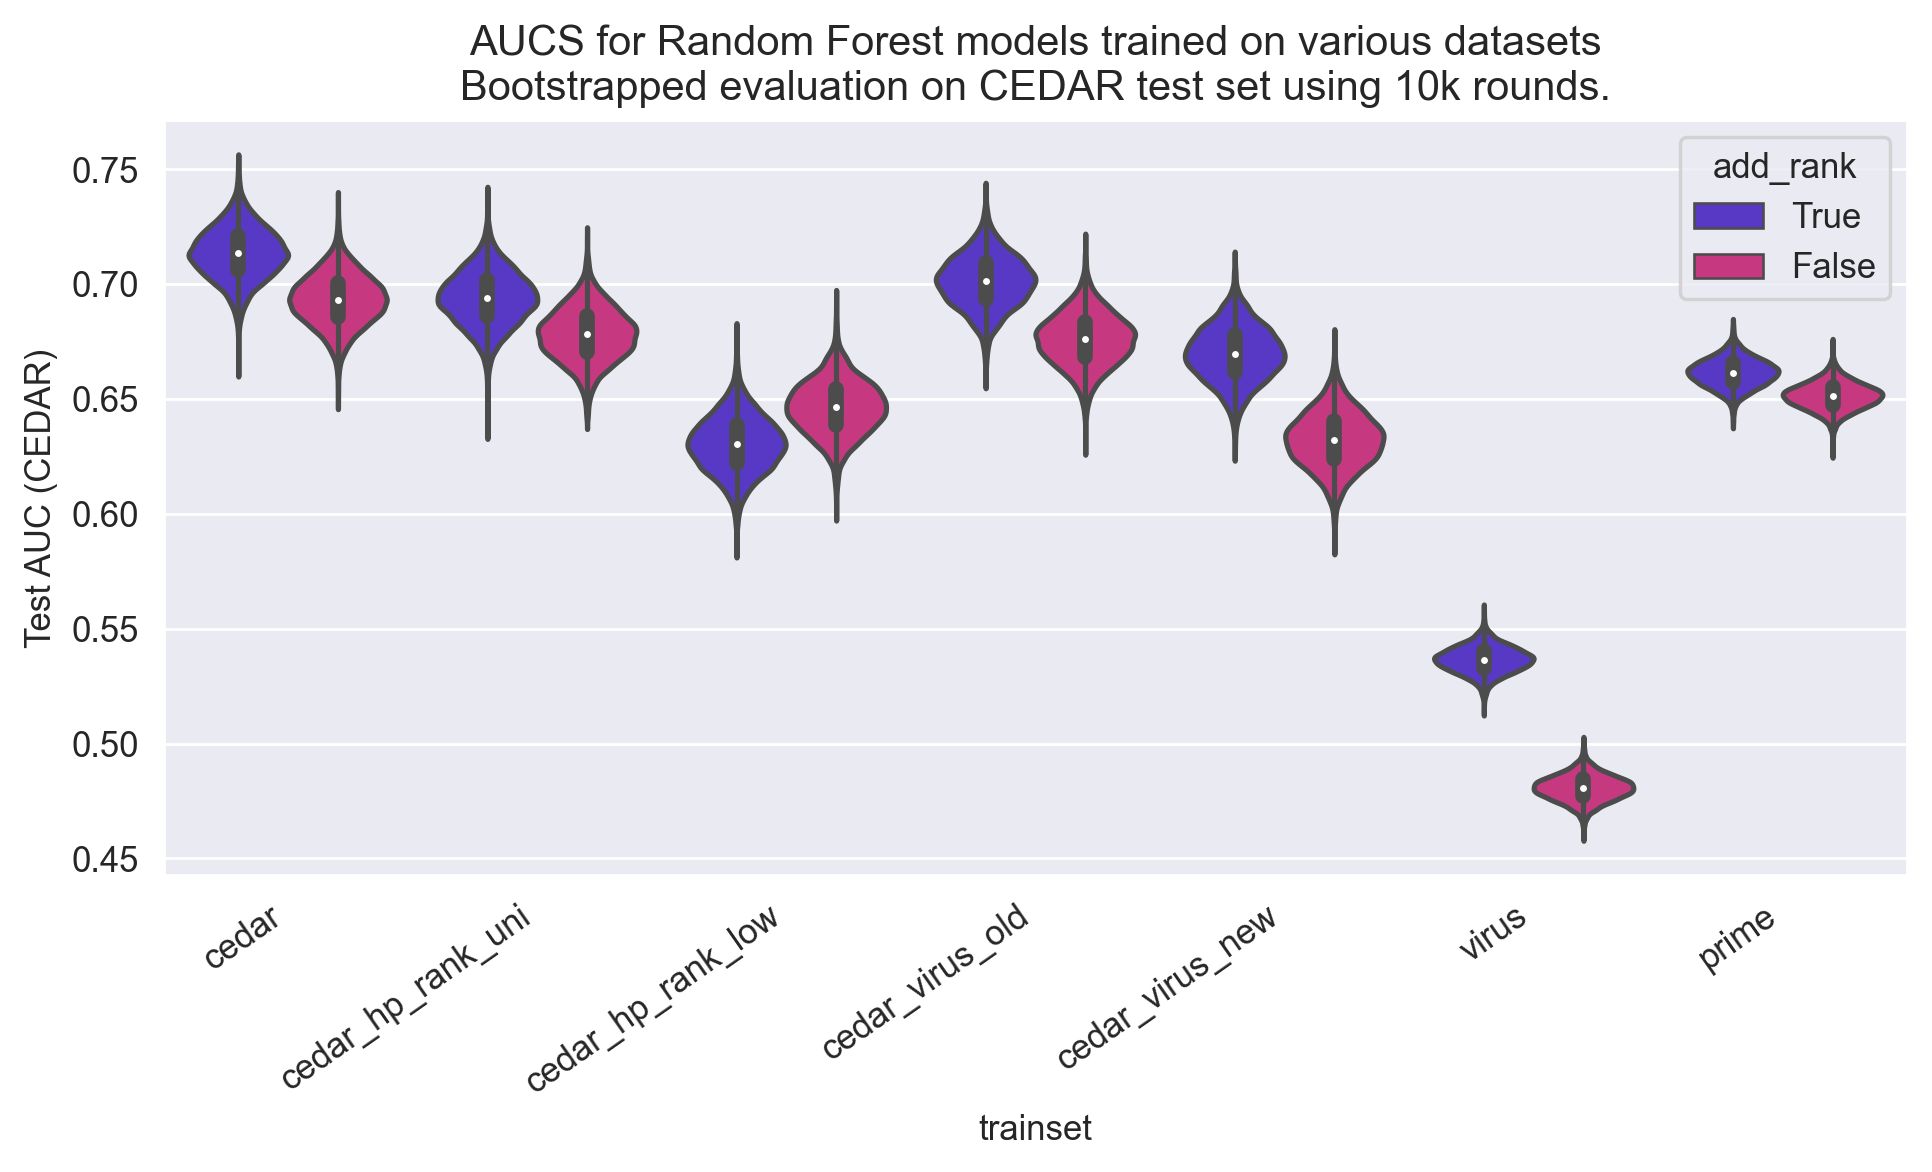

In [61]:
# Overall boxplot
f,a = plt.subplots(1,1, figsize=(9,4))
sns.set_palette([HSV[0], HSV[1]])
x_order = ['cedar', 'cedar_hp_rank_uni', 'cedar_hp_rank_low', 'cedar_virus_old', 'cedar_virus_new', 'virus', 'prime']
sns.violinplot(data=df_rank_trainset_model_cedar.query('model=="RF"'), ax=a, hue_order = [True, False],
            x='trainset', hue='add_rank', y='auc', saturation = 0.55, alpha = 0.255,
            order = x_order)
a.set_xticklabels(labels = x_order, rotation = 35, fontdict={'horizontalalignment':'right'})
a.set_title('AUCS for Random Forest models trained on various datasets\nBootstrapped evaluation on CEDAR test set using 10k rounds.')
a.set_ylabel('Test AUC (CEDAR)')

In [ ]:
df_features = pd.concat([x['cedar_df'] for x in features_results])

In [ ]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,6))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.violinplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, cut=0, dodge=False,
              legend_kws = {'loc':'lower right'})#, boxprops=dict(alpha=.75))
plt.setp(a[0].collections, alpha=.75)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
# pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
# New P-val calculation, 1 - M/N
pval = 1 - (len((rank_true>rank_false).astype(int).nonzero()[0]) / len(rank_true) )
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.79])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[0].legend(loc = 'lower right')
a[0].set_title('Effect of adding rank\nUsing RandomForest as model')


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.violinplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, cut=0,
               legend_kws = {'loc':'lower right'}
              )
# Manually sets the alpha for this collection in the axis a[1] object
plt.setp(a[1].collections, alpha=.75)
# sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              # ax = a[1], alpha = 0.6, size = 1.25, dodge=False)
a[0].set_ylabel('Test AUC (CEDAR)')
score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values

pval = 1 - (len((score_rf>score_xgb).astype(int).nonzero()[0]) / len(score_xgb) )
label= f'*\np={pval:.4e}' if pval<0.025 else f'ns, p={pval:.4f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .77-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.79])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
a[1].legend(loc = 'lower right')
a[1].set_title('Comparison of models\nUsing add_rank==True')
# a.set_title(binder)
f.tight_layout(pad=5.75)
f.suptitle('Comparison of models and effect of adding rank.\nWith bootstrapped p-values (n=10000)\nBootstrapped evaluation on CEDAR test set with 10k rounds',
          fontweight='semibold', fontsize=14)

In [62]:
df_features = pd.read_csv('../output/bootstrapping/features_results.csv')

In [63]:
df_features.replace({'BL62FREQ':'onehot'},inplace=True)

In [64]:
mapname={'TrueTrueFalse': 'Base features + %Rank and PC props',
         'TrueFalseFalse': 'Base features + %Rank',
         'FalseTrueFalse': 'Base features + PC props',
         'FalseFalseFalse': 'Base features only',
         'TrueTrueTrue': 'Rank & PC props only'}
df_features['Features'] = df_features.apply(lambda x: mapname[str(x['add_rank'])+str(x['add_aaprop'])+str(x['remove_pep'])], axis=1)

tmp = df_features.query('Features in ["Base features + %Rank and PC props","Base features + %Rank","Base features only"]')
df = tmp.query('(weight=="None" or weight=="Shannon") and remove_pep==False')

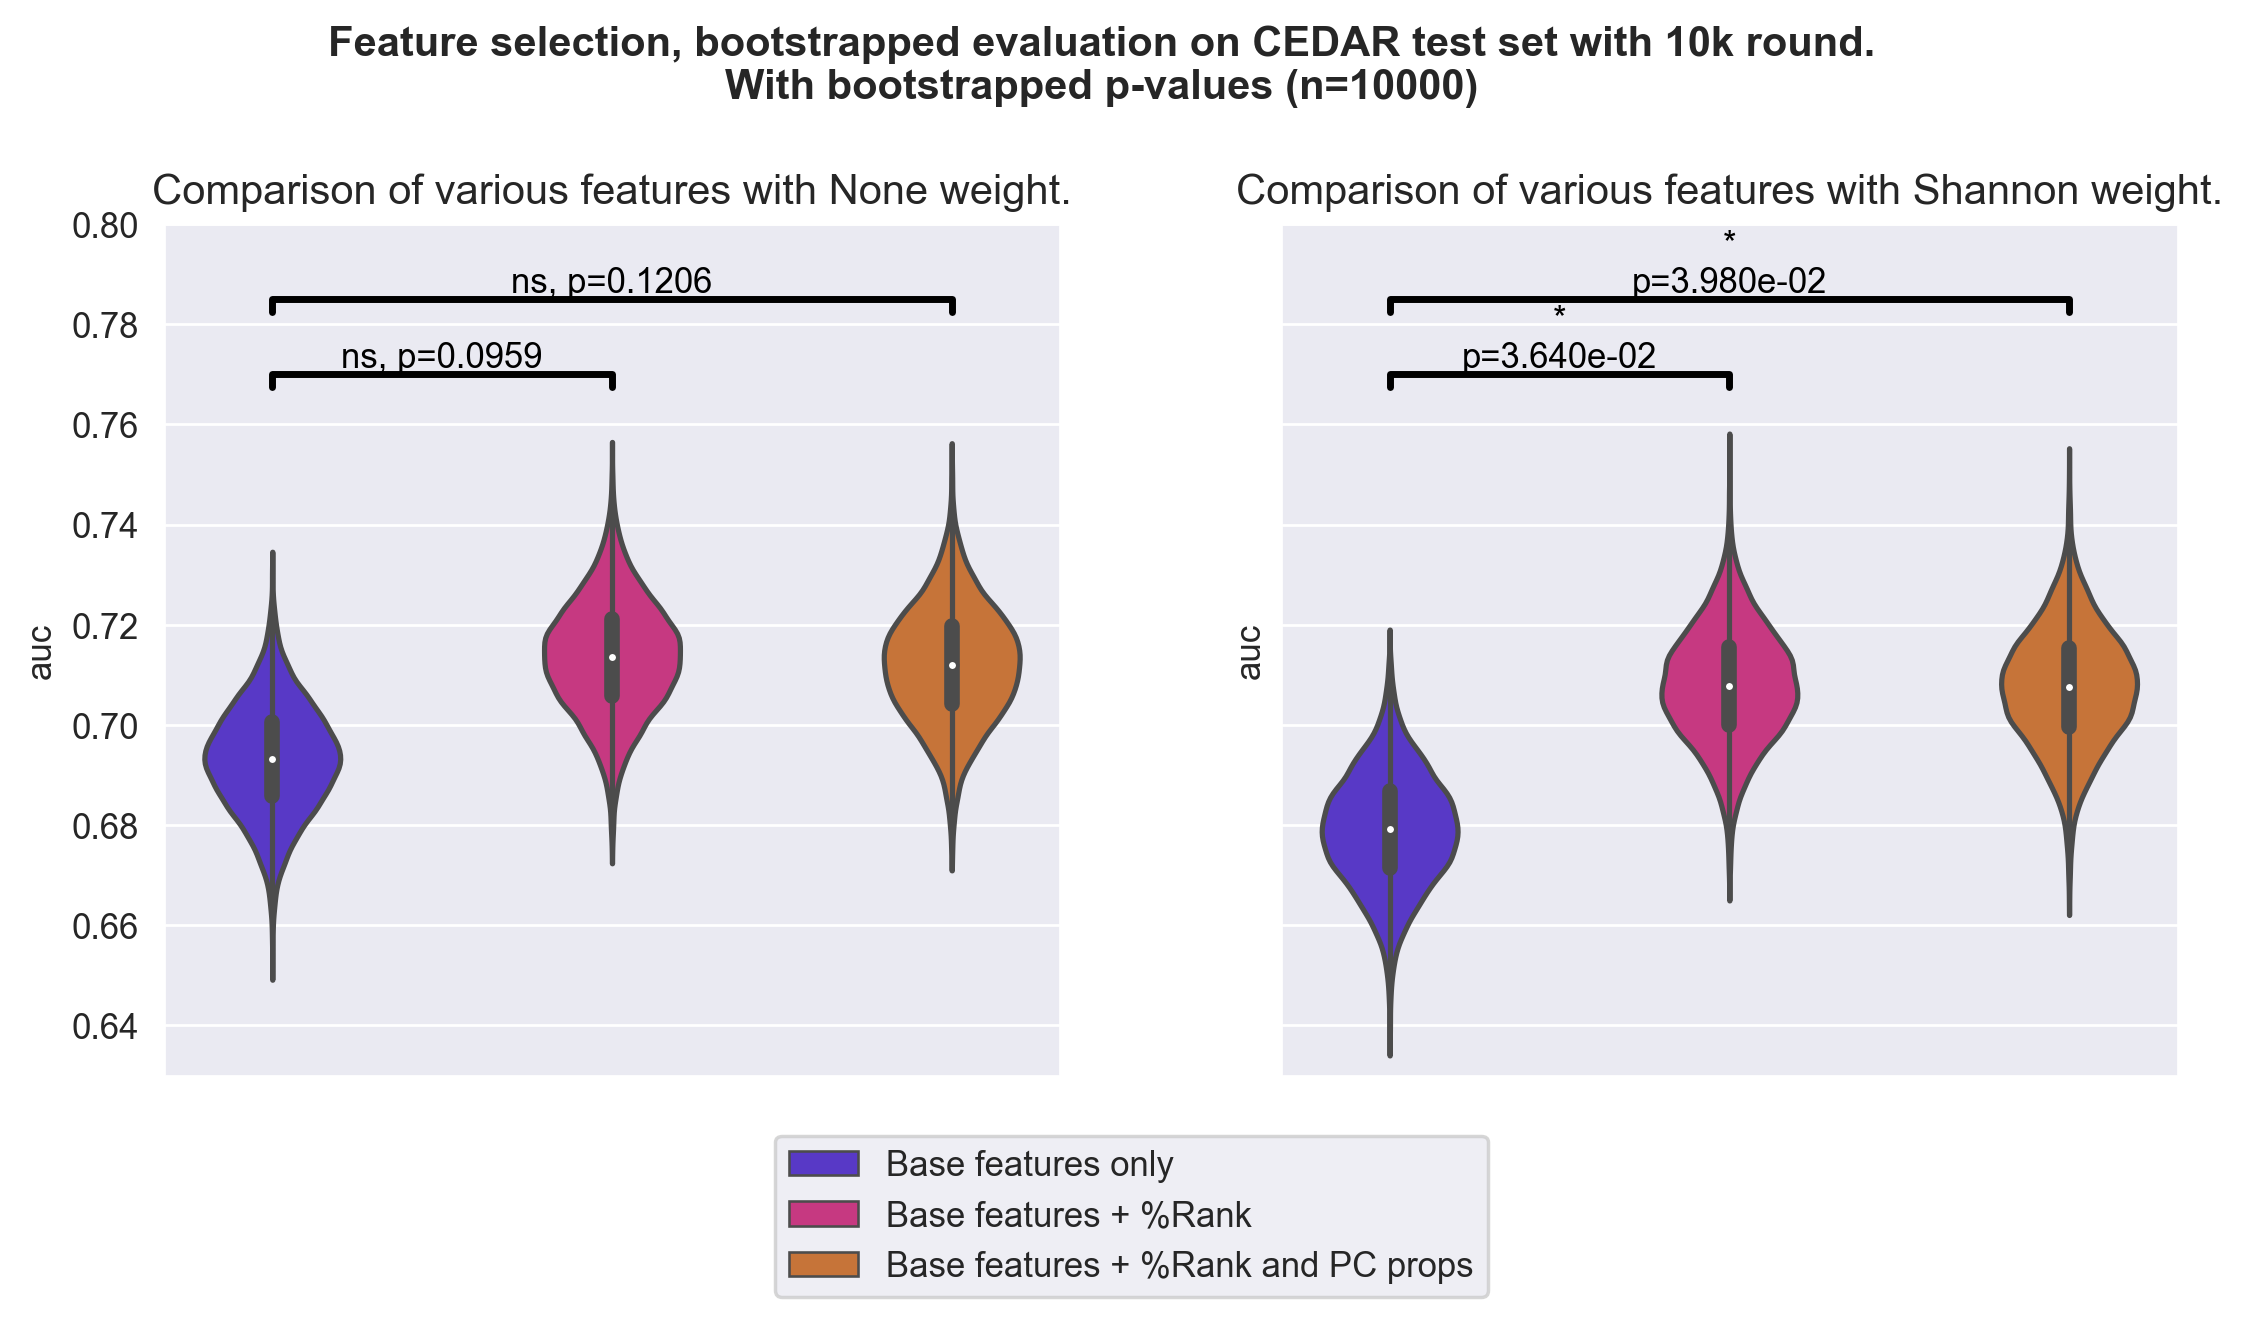

In [68]:
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(10,5),sharey=True)

for i, weight in enumerate(['None', 'Shannon']):
    order = ['Base features only', 'Base features + %Rank','Base features + %Rank and PC props']
    tmp = df.query('weight == @weight')
    sns.violinplot(data=tmp, y='auc', hue = 'Features', x = 'Features', width=.4,
                   dodge= False, cut = 0, saturation=0.55, alpha=0.35,
                   ax=a[i], hue_order = order, order=order)
    a[i].set_xticklabels([None,None,None])
    a[i].set_xlabel(None)
    a[i].set_ylim([.63, .8])
    base_auc = tmp.query("Features == 'Base features only'")['auc'].values
    rank_auc = tmp.query("Features == 'Base features + %Rank'")['auc'].values
    all_auc = tmp.query("Features == 'Base features + %Rank and PC props'")['auc'].values
    
    pval_rank = 1-(len((rank_auc>base_auc).astype(int).nonzero()[0]) / len(base_auc))
    pval_all = 1-(len((all_auc>base_auc).astype(int).nonzero()[0]) / len(base_auc))
    
    label_rank= f'*\np={pval_rank:.3e}' if pval_rank<0.05 else f'ns, p={pval_rank:.4f}'
    label_all= f'*\np={pval_all:.3e}' if pval_all<0.05 else f'ns, p={pval_all:.4f}'
    
    # Drawing Pval */ns rectangles
    x1, x2, x3 = 0, 1, 2
    y1, h1, col = .77-0.0025, 0.0025, 'k'
    y2, h2 = .785-0.0025, 0.0025
    # Drawing for rank 
    a[i].plot([x1,x1,x2,x2], [y1, y1+h1, y1+h1, y1], lw = 2, c=col)
    a[i].text((x1+x2)*.5, y1+h1, label_rank, ha = 'center', va = 'bottom', color = col)
    # Drawing for rank+props
    a[i].plot([x1,x1,x3,x3], [y2, y2+h2, y2+h2, y2], lw = 2, c=col)
    a[i].text((x1+x3)*.5, y2+h2, label_all, ha = 'center', va = 'bottom', color = col)
    
    a[i].set_title(f'Comparison of various features with {weight} weight.')
    # a.set_title(binder)
a[0].legend([], [], frameon=False)
f.tight_layout(pad=5)
f.suptitle('Feature selection, bootstrapped evaluation on CEDAR test set with 10k round.\nWith bootstrapped p-values (n=10000)',
          fontweight='semibold', fontsize=12)
a[1].legend(bbox_to_anchor=(.25, -.05))


## best features

In [ ]:
df_trainset = pd.read_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv')
df_weight = pd.read_csv('../output/bootstrapping/df_pval_redo_encoding_weight.csv')
all_dfs = pd.concat([df_trainset, df_weight, df_features])

In [ ]:
df_features.groupby(['weight', 'Features']).agg(mean_auc = ('auc', 'mean'),
                                                max_auc = ('auc', 'max'))\
           .sort_values('mean_auc', ascending=False).head(6)\
           .rename(columns = {'mean_auc': 'Mean AUC (CEDAR test set)',
                              'max_auc': 'Max AUC (CEDAR test set)'})


In [ ]:
idx_shannon = 0
idx_none = 0
for i, x in enumerate(features_results):
    if x['add_rank'] != True:
        continue
    else:
        if x['add_aaprop']!=True and x['remove_pep']!=True:
            if x['cedar_df']['weight'].unique().item()=='Shannon':
                idx_shannon =i
            if x['cedar_df']['weight'].unique().item()=='None':
                idx_none=i
        else:
            continue
            


In [ ]:
cedar_roc_shannon = features_results[idx_shannon]['cedar_rocs']
prime_roc_shannon = features_results[idx_shannon]['prime_rocs']

cedar_roc_shannon = features_results[idx_shannon]['cedar_rocs']
prime_roc_shannon = features_results[idx_shannon]['prime_rocs']



In [170]:
logreg=pkl_load('../output/train_eval/_old/run_220826_13h42m44s_logreg/train_metrics_log.pkl')

In [171]:
logreg

KeyboardInterrupt: 